<a href="https://colab.research.google.com/github/MatteoFasulo/Sexism-detection/blob/main/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sexism Detector - Assignment 1

## Group:
- Luca Babboni - luca.babboni2@studio.unibo.it  
- Matteo Fasulo - matteo.fasulo@studio.unibo.it  
- Maksim Omelchenko - maksim.omelchenko@studio.unibo.it  
- Luca Tedeschini - luca.tedeschini3@studio.unibo.it  

## Description:
This notebook addresses Task 1 proposed in [EXIST 2023](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection. The following work follows, step by step, the tasks specified in the provided notebook.


# Libraries

Uncomment the following cell to install the required libraries in Google Colab.

In [1]:
#%%capture
#%pip install requests nltk gensim datasets evaluate transformers

In [1]:
import requests
import gc
import os
from pathlib import Path
import re
import json
from typing import OrderedDict
import copy

import unicodedata

import numpy as np
import pandas as pd

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay

from tqdm import tqdm
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer

import gensim
import gensim.downloader as gloader

import torch

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import XLMRobertaForSequenceClassification

/home/sbrodox/Desktop/githubrepos/Sexism-detection/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Class Definition

We decided to organize all the code within classes to keep the outputs well-organized and clean. 

Each method is documented with its respective docstring, and a high-level explanation of what we are doing will be written in markdown whenever we call the methods.

<div class="alert alert-info">
<b> Note: </b>We hope that in this way the code will be more readable and understandable.
</div>

In [2]:
class SexismDetector:
    def __init__(self):
        URL_PATTERN_STR = r"""(?i)((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info
                      |int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|
                      bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|
                      cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|
                      gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|
                      la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|
                      nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|
                      sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|
                      uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]
                      *?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’])|(?:(?<!@)
                      [a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name
                      |post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn
                      |bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg
                      |eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id
                      |ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|
                      md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|
                      ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|
                      sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|
                      za|zm|zw)\b/?(?!@)))"""
        self.URL_PATTERN = re.compile(URL_PATTERN_STR, re.IGNORECASE)
        self.HASHTAG_PATTERN = re.compile(r'#\w*')
        self.MENTION_PATTERN = re.compile(r'@\w*')
        self.EMOJIS_PATTERN = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
        self.AND_PATTERN = re.compile(r'&amp;')
        self.PUNCT_REPEAT_PATTERN = re.compile(r'([!?.]){2,}')
        self.ELONG_PATTERN = re.compile(r'\b(\S*?)(.)\2{2,}\b')
        self.WORD_PATTERN = re.compile(r'[^\w<>\s]')
        self.SEED = 1337
        self.DATA_FOLDER = Path('data')
        self.MODEL_FOLDER = Path('models')
        self.IMG_FOLDER = Path('images')
        self.CSV_FOLDER = Path('csv')
        self.columns_to_maintain = ['id_EXIST', 'lang', 'tweet', 'hard_label_task1']
        self.UNK_TOKEN = '[UNK]'
        self.PAD_TOKEN = '[PAD]'

        if not self.CSV_FOLDER.exists():
            self.CSV_FOLDER.mkdir(parents=True)
            print(f"Created folder {self.CSV_FOLDER}.")

    def download_corpus(self, url: str, filename: str) -> None:
        """
        Downloads a text corpus from a given URL and saves it to a specified filename within the data folder.

        Args:
            url (str): The URL from which to download the corpus.
            filename (str): The name of the file to save the downloaded corpus.

        Raises:
            requests.exceptions.HTTPError: If the HTTP request returned an unsuccessful status code.

        Side Effects:
            Creates the data folder if it does not exist.
            Writes the downloaded corpus to the specified file.
        """
        if not self.DATA_FOLDER.exists():
            self.DATA_FOLDER.mkdir(parents=True)
            print(f"Created folder {self.DATA_FOLDER}.")

        response = requests.get(url)
        response.raise_for_status()
        with open(self.DATA_FOLDER / filename, 'w', encoding='utf-8') as f:
            f.write(response.text)

    def load_corpus(self, filename: str, *args, **kwargs) -> pd.DataFrame:
        """
        Load a corpus from a JSON file.

        Parameters:
        filename (str): The name of the JSON file to load.
        *args: Variable length argument list to pass to pandas read_json.
        **kwargs: Arbitrary keyword arguments to pass to pandas read_json.

        Returns:
        DataFrame: A pandas DataFrame containing the loaded corpus.
        """
        return pd.read_json(self.DATA_FOLDER / filename, *args, **kwargs)

    @staticmethod
    def majority_voting(votes: list[str]) -> str:
        """
        Determines the majority vote from a list of votes.
        Args:
            votes (list[str]): A list of votes, where each vote is either "YES" or "NO".
        Returns:
            str: The result of the majority vote. Returns "YES" if there are more "YES" votes,
                "NO" if there are more "NO" votes, and "NEUTRAL" in case of a tie.
        """
        total_num_votes = len(votes)
        yes_votes = votes.count("YES")
        no_votes = total_num_votes - yes_votes

        if yes_votes > no_votes:
            return "YES"
        elif no_votes > yes_votes:
            return "NO"
        else:
            return "NEUTRAL" # This will be the case when there is a tie (removed later)

    def preprocess_text(self, text: str) -> str:
        """
        Preprocesses the input text by removing or replacing specific patterns.

        Args:
            text (str): The input text to be preprocessed.

        Returns:
            str: The preprocessed text with URLs, mentions, hashtags, emojis,
                 special characters removed, 'and' replaced, and extra spaces trimmed.
        """
        # Convert URL to <URL> so that GloVe will have a vector for it
        text = re.sub(self.URL_PATTERN, ' <URL>', text)
        # Add spaces around slashes
        text = re.sub(r"/", " / ", text)
        # Replace mentions with <USER>
        text = re.sub(self.MENTION_PATTERN, ' <USER> ', text)
        # Replace numbers with <NUMBER>
        text = re.sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", " <NUMBER> ", text)
        # Replace hashtags with <HASHTAG>
        text = re.sub(self.HASHTAG_PATTERN, ' <HASHTAG> ', text)
        #text = self.AND_PATTERN.sub('and', text) # &amp; already in the Vocab of GloVe-twitter
        # Replace multiple punctuation marks with <REPEAT>
        text = re.sub(self.PUNCT_REPEAT_PATTERN, lambda match: f" {match.group(1)} <REPEAT> ", text)
        # Replace elongated words with <ELONG>
        text = re.sub(self.ELONG_PATTERN, lambda match: f" {match.group(1)}{match.group(2)} <ELONG> ", text)
        #text = emoji.replace_emoji(text, replace='') # some emojis are in the vocab so we do not remove them, the others will be OOVs
        text = text.strip()
        # Get only words
        text = re.sub(self.WORD_PATTERN, ' ', text)
        text = text.strip()
        # Convert stylized Unicode characters to plain text (removes bold text, etc.)
        text = ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c))
        return text

    def lemmatize_text(self, text: str) -> str:
        """
        Lemmatizes the input text using the WordNet lemmatizer.

        This method attempts to lemmatize each word in the input text. If the WordNet
        data is not available, it will download the necessary data and retry.

        Args:
            text (str): The input text to be lemmatized.

        Returns:
            str: The lemmatized text.
        """
        lemmatizer = WordNetLemmatizer()
        downloaded = False
        while not downloaded:
            try:
                lemmatizer.lemmatize(text)
                downloaded = True
            except LookupError:
                print("Downloading WordNet...")
                nltk.download('wordnet')
        return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    @staticmethod
    def text_diff(original_text: str, preprocessed_text: str, random: bool = True) -> None:
        """
        Displays a comparison between an original tweet and its preprocessed version.
        Args:
            original_text (str): The original text data containing tweets.
            preprocessed_text (str): The preprocessed text data containing tweets.
            random (bool, optional): If True, a random tweet is selected for comparison.
                                     If False, the first tweet is selected. Defaults to True.
        Returns:
            None
        """
        if random:
            idx = np.random.randint(0, preprocessed_text.shape[0])
        else:
            idx = 0

        print(f"Original tweet:\n{original_text['tweet'].iloc[idx]}")
        print(f"Processed tweet:\n{preprocessed_text['tweet'].iloc[idx]}")

    def load_glove(self, model_name: str = 'glove-wiki-gigaword', embedding_dim: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
        """
        Loads the GloVe model with the specified name and embedding dimension.
        Args:
            model_name (str): The name of the GloVe model to load. Default is 'glove-wiki-gigaword'.
            embedding_dim (int): The dimension of the word embeddings. Default is 50.
        Returns:
            gensim.models.keyedvectors.KeyedVectors: The loaded GloVe model.
        Raises:
            Exception: If there is an error in downloading or loading the model.
        Notes:
            - If the model folder does not exist, it will be created.
            - If the model is not already downloaded, it will be downloaded and saved to the specified path.
            - If the model is already downloaded, it will be loaded from the specified path.
        """
        self.EMBEDDING_DIM = embedding_dim

        if not self.MODEL_FOLDER.exists():
            self.MODEL_FOLDER.mkdir(parents=True)
            print(f"Created folder {self.MODEL_FOLDER}.")

        model_path = self.MODEL_FOLDER / f"{model_name}-{embedding_dim}"
        if not model_path.exists():
            print(f"Downloading {model_name} model...")
            glove_model = gloader.load(f"{model_name}-{embedding_dim}")
            print(f"Model downloaded! Saving to {model_path}")
            glove_model.save(str(model_path))
            print(f"Model saved to {self.MODEL_FOLDER / f'{model_name}-{embedding_dim}'}")
        else:
            glove_model = gensim.models.keyedvectors.KeyedVectors.load(str(model_path))
        return glove_model

    def get_vocab(self, data: pd.DataFrame) -> tuple[OrderedDict, OrderedDict]:
        """
        Generates vocabulary mappings from a given dataset.
        Args:
            data (pd.DataFrame): A pandas DataFrame containing the dataset with a column 'tweet'.
            word_listing (list, optional): A list of words to include in the vocabulary. If None, the vocabulary
                                           will be built from the dataset. Defaults to None.
        Returns:
            tuple[OrderedDict, OrderedDict]: A tuple containing two OrderedDicts:
                - idx_to_word: Mapping from index to word.
                - word_to_idx: Mapping from word to index.
        """
        idx_to_word = OrderedDict()
        word_to_idx = OrderedDict()

        curr_idx = 0
        for sentence in data.tweet.values:
            tokens = sentence.split()
            for token in tokens:
                if token not in word_to_idx:
                    word_to_idx[token] = curr_idx
                    idx_to_word[curr_idx] = token
                    curr_idx += 1

        word_listing = list(idx_to_word.values())
        return idx_to_word, word_to_idx, word_listing

    def co_occurrence_count(self, df: pd.DataFrame, idx_to_word, word_to_idx, window_size: int = 10) -> np.ndarray:

        vocab_size = len(idx_to_word)
        co_occurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)

        for sentence in tqdm(df.tweet.values):
            tokens = sentence.split()
            for pos, token in enumerate(tokens):
                start = max(0, pos - window_size)
                end = min(pos + window_size + 1, len(tokens))

                first_word_index = word_to_idx[token]

                for pos2 in range(start, end):
                    if pos2 != pos:
                        second_token = tokens[pos2]
                        second_word_index = word_to_idx[second_token]
                        co_occurrence_matrix[first_word_index, second_word_index] += 1

        return co_occurrence_matrix

    def co_occurrence_dataframe(self, co_occurrence_matrix: np.ndarray, idx_to_word: OrderedDict) -> pd.DataFrame:
        """
        Converts a co-occurrence matrix into a pandas DataFrame with word indices as row and column labels.
        Args:
            co_occurrence_matrix (np.ndarray): A co-occurrence matrix with word indices as row and column indices.
            idx_to_word (OrderedDict): A mapping from word index to word.
        Returns:
            pd.DataFrame: A pandas DataFrame with word indices as row and column labels.
        """
        return pd.DataFrame(co_occurrence_matrix, index=idx_to_word.values(), columns=idx_to_word.values())

    def get_augmented_vocab(self, emb_model: gensim.models.keyedvectors.KeyedVectors, train_words: list, co_occurrence_df: pd.DataFrame, save: bool = False) -> gensim.models.keyedvectors.KeyedVectors:
        """
        Augments the given embedding model with new tokens from the training words list. If a token is not found in the
        embedding model, a random vector is generated for it. Optionally saves the updated vocabulary to a JSON file.
        Args:
            emb_model (gensim.models.keyedvectors.KeyedVectors): The embedding model to augment.
            train_words (list): A list of words to add to the embedding model.
            co_occurrence_df (pd.DataFrame): A DataFrame containing co-occurrence data for the training words.
            save (bool, optional): If True, saves the updated vocabulary to a JSON file. Defaults to False.
        Returns:
            gensim.models.keyedvectors.KeyedVectors: The augmented embedding model.
        """
        new_tokens = []
        new_vectors = []

        for token in train_words:
            try:
                embedding_vec = emb_model.get_vector(token)
            except KeyError:
                try:
                    # Handle missing token in embedding model
                    top_5_most_frequent = co_occurrence_df.loc[token].sort_values(ascending=False).index.tolist()[:5] # Get the top 5 most frequent co-occurring words

                    # Filter words that are in the embedding model
                    valid_words = [word for word in top_5_most_frequent if word in emb_model.key_to_index]

                    if valid_words: # TODO: check that valid words as atleast 2 words otherwise mean won't be significant
                        # Calculate the average vector for valid words
                        embedding_vec = np.mean([emb_model.get_vector(word) for word in valid_words], axis=0)
                    else:
                        # Handle the case where no valid co-occurring words exist
                        raise ValueError(f"No valid co-occurring words found for token: {token}")

                except Exception as e:
                    print(f"Generating random vector for token '{token}': {e}")
                    embedding_vec = np.random.uniform(low=-0.05, high=0.05, size=self.EMBEDDING_DIM)

            new_tokens.append(token)
            new_vectors.append(embedding_vec)

        emb_model.add_vectors(new_tokens, new_vectors)
        # add the UNK token to the embedding model with the vector which is the average of all the vectors
        emb_model.add_vectors(["[UNK]", "[PAD]"], [np.mean(emb_model.vectors, axis=0), np.zeros(self.EMBEDDING_DIM)])

        if save:
            vocab_path = self.DATA_FOLDER / 'vocab.json'
            print(f"Saving vocab to {vocab_path}")
            with vocab_path.open('w', encoding='utf-8') as f:
                json.dump(emb_model.key_to_index, f, indent=4)
            print("Vocab saved!")

        return emb_model

    def get_oov(self, embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing: list) -> set:
        """
        Returns a list of out-of-vocabulary (OOV) words from a given list of words.
        Args:
            embedding_model (gensim.models.keyedvectors.KeyedVectors): The word embedding model containing known words.
            word_listing (list): A list of words to check against the embedding model.
        Returns:
            set: A set of out-of-vocabulary words.
        """
        return set(word_listing).difference(set(embedding_model.key_to_index.keys()))

    def get_oov_stats(self, embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing: list) -> None:
        """
        Calculate and print the number and percentage of out-of-vocabulary (OOV) words.
        Args:
            embedding_model (gensim.models.keyedvectors.KeyedVectors): The word embedding model containing known words.
            word_listing (list): A list of words to check against the embedding model.
        Returns:
            None
        """
        OOV_token = self.get_oov(embedding_model, word_listing)
        OOV_percentage = float(len(OOV_token)) * 100 / len(word_listing)

        print(f"Total OOV terms: {len(OOV_token)} ({OOV_percentage:.2f}%)")

    def get_class_weights(self, data: pd.DataFrame, label_column: str) -> np.ndarray:
        """
        Computes class weights for a given dataset.
        Args:
            data (pd.DataFrame, optional): A pandas DataFrame containing the dataset. Defaults to None.
        Returns:
            np.ndarray: An array of class weights.
        """
        class_weights = compute_class_weight('balanced', classes=np.unique(data[label_column]), y=data[label_column])
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32)
        return self.class_weights

    def get_padded_sequences(self, data: pd.Series, embedding_model: gensim.models.keyedvectors.KeyedVectors) -> torch.Tensor:
        """
        Converts a pandas Series of text data into padded sequences of word indices using a given embedding model.

        Args:
            data (pd.Series): A pandas Series containing text data.
            embedding_model (gensim.models.keyedvectors.KeyedVectors): A pre-trained word embedding model.

        Returns:
            torch.Tensor: A tensor containing padded sequences of word indices.
        """
        tokenizer = nltk.tokenize.NLTKWordTokenizer()
        unk_index = embedding_model.get_index(self.UNK_TOKEN)

        sequences = [torch.tensor([embedding_model.get_index(word, default=unk_index) for word in tokenizer.tokenize(x)]) for x in data.values]

        return torch.nn.utils.rnn.pad_sequence(sequences, padding_value=embedding_model.get_index(self.PAD_TOKEN), batch_first=True)

    def get_dataloader(self, data: pd.DataFrame, embedding_model: gensim.models.keyedvectors.KeyedVectors, type: str, *args, **kwargs) -> torch.utils.data.DataLoader:
        """
        Creates a DataLoader for the given dataset.

        Args:
            data (pd.DataFrame): DataFrame containing the data. Must have 'tweet' and 'label' columns.
            embedding_model (gensim.models.keyedvectors.KeyedVectors): Pre-trained embedding model to convert tweets to vectors.
            type (str): Type of dataset. Must be one of 'train', 'val', or 'test'.
            *args: Variable length argument list for DataLoader.
            **kwargs: Arbitrary keyword arguments for DataLoader.

        Returns:
            torch.utils.data.DataLoader: DataLoader for the given dataset.

        Raises:
            ValueError: If the type is not one of 'train', 'val', or 'test'.
        """
        if type not in ['train', 'val', 'test']:
            raise ValueError("Invalid type. Must be one of 'train', 'val', or 'test'.")
        padded_sequences = self.get_padded_sequences(data.tweet, embedding_model)
        labels = torch.tensor(data.label.values)
        dataset = TextDataset(padded_sequences, labels)
        return torch.utils.data.DataLoader(dataset, *args, **kwargs)

class TextDataset(torch.utils.data.Dataset):
    """
    A custom dataset class for handling text sequences and their corresponding labels.

    Args:
        sequences (torch.Tensor): A tensor containing the text sequences.
        labels (torch.Tensor): A tensor containing the labels for each text sequence.

    Attributes:
        sequences (torch.Tensor): Stores the text sequences.
        labels (torch.Tensor): Stores the labels for each text sequence.

    Methods:
        __len__(): Returns the number of text sequences in the dataset.
        __getitem__(idx): Returns the text sequence and label at the specified index.
    """
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return self.sequences.shape[0]

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Task 1: Corpus

1. Download the data
2. Load the JSON files and encode them as a DataFrame
3. Generate hard labels for Task 1 with majority voting
4. Filter the DataFrame for only english tweets
5. Remove unwanted columns
6. Encode the hard labels column as integers

<div class="alert alert-info">
<b>Bonus</b>: explore also Spanish tweets leveraging multi-language models and assessing the performance of the model on the two languages in comparison to the English-only model.
</div>

By setting the following environment variable, CUDA should adopt some deterministic algorithms to ensure reproducibility. 

<div class="alert alert-info">
<b> Note: </b>We are not sure of whether this will work but <a href="https://pytorch.org/docs/stable/notes/randomness.html#:~:text=Furthermore%2C%20if%20you%20are%20using%20CUDA%20tensors%2C%20and%20your%20CUDA%20version%20is%2010.2%20or%20greater%2C%20you%20should%20set%20the%20environment%20variable%20CUBLAS_WORKSPACE_CONFIG%20according%20to%20CUDA%20documentation%3A%20https%3A//docs.nvidia.com/cuda/cublas/index.html%23results%2Dreproducibility"> it was mentioned in the PyTorch documentation</a>.</div>

In [3]:
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

Fist of all, we need to instantiate the class which we will use to perform the task.

In [4]:
detector = SexismDetector()

We will the device to use for the computation of PyTorch models. If a GPU is available, we will use it, otherwise we will use the CPU.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Constants

The constants are defined in the following cell. We will use them to define the embedding dimension and batch size.

We will also instantiate an empty dictionary which will store the predictions and labels of each model for both the validation and test sets. In this way at the end we will have a single data structure (also easily exportable to a file) that will contain all the information we need to evaluate the models.

<br>
<div class="alert alert-info">
<b>Note</b>: the dictionary will have the following structure:
</div>

```python
{
    "model_name": {
        "validation": {
            "predictions": [],
            "labels": []
        },
        "test": {
            "predictions": [],
            "labels": []
        }
    }
}
```

In [6]:
# GloVe Embeddings
EMBEDDING_DIM = 50

# LSTMs
BATCH_SIZE = 128 # good balance between speed and performance
HIDDEN_DIM = 1024 # very costly on the GPU but gives better results on 2-layer LSTM
EPOCHS = 60 # just a starting point, we will use early stopping
LEARNING_RATE = 1e-4 # starting point for the learning rate search

# Transformers (roBERTa)
ROBERTA_BATCH_SIZE = 16
ROBERTA_EPOCHS = 6
ROBERTA_LEARNING_RATE = 5e-6

# Set the seeds for reproducibility
seeds = [1337, 42, 69]

# Instantiate the predictions dict to store the predictions for each seed and model (LSTMs and Transformers)
predictions_dict = {}

here we also defined the three seeds which we will use to ensure the reproducibility of the results. 

<div class="alert alert-info">
<b> Note: </b>All the models will be trained on each of the three seeds and the final results will be the <b>majority voting</b> of the three models. We will discuss which is the best model and on what seed it was trained but the confusion matrices and the final results will be the majority voting of the three models.
</div>

### Download the data

The data is downloaded from the repository of the course. 

<div class="alert alert-info">
<b> Note: </b>The `download_corpus` method is used to download the data from the repository and save it in the `data` folder under the root directory of the project.
</div>

In [7]:
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/training.json', filename='training.json')
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/test.json', filename='test.json')
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/validation.json', filename='validation.json')

### Load the JSON files and encode them as a DataFrame

Then we load the JSON files and encode them as a DataFrame. 
<div class="alert alert-info">
<b> Note: </b>The `load_corpus` method is used to load the data from the JSON files and encode them as a DataFrame.

In [8]:
train = detector.load_corpus('training.json', orient='index', encoding='utf-8')
val = detector.load_corpus('validation.json', orient='index', encoding='utf-8')
test = detector.load_corpus('test.json', orient='index', encoding='utf-8')

Make a copy of the test set to be used at the end to perform more in depth analysis about why the model is failing to classify the tweets. This will be useful at the end of the Notebook to understand the reasons behind the misclassification of the tweets.

In [9]:
test_copy = test.copy()

### Data exploration

We can briefly explore the dataset we are working with by inspecting the first few rows of the DataFrame and the shape of the dataset.

In [10]:
train.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


In [11]:
train.shape, val.shape, test.shape

((6920, 11), (726, 11), (312, 11))

### Generate hard labels for Task 1 with majority voting

The hard labels for Task 1 are generated with majority voting. 
<div class="alert alert-info">
<b> Note: </b>The `majority_voting` method is used to generate the hard labels for <b>Task 1</b> with majority voting. In case of a tie, the label is set to `NEUTRAL` allowing for later filtering of the data.

In [12]:
train['hard_label_task1'] = train['labels_task1'].apply(detector.majority_voting)
val['hard_label_task1'] = val['labels_task1'].apply(detector.majority_voting)
test['hard_label_task1'] = test['labels_task1'].apply(detector.majority_voting)

### Filter the DataFrame for only english tweets and remove neutral tweets

Since the task requires to work only with English tweets, we filter the DataFrame. 
<div class="alert alert-info">
<b> Note: </b>Here we also remove all the rows with neutral labels (i.e. ties in the majority voting).

In [13]:
train = train[(train['hard_label_task1'] != "NEUTRAL") & (train['lang'] == "en")]
val = val[(val['hard_label_task1'] != "NEUTRAL") & (val['lang'] == "en")]
test = test[(test['hard_label_task1'] != "NEUTRAL") & (test['lang'] == "en")]

As we can see we have less rows than before, since we removed all the rows with neutral labels and all the rows with tweets in languages different from English.

In [14]:
train.shape, val.shape, test.shape

((2870, 12), (158, 12), (286, 12))

### Remove unwanted columns

After that, we remove the unwanted columns from the DataFrame to keep only the columns we need for the task (the text of the tweet and the hard labels).

In [15]:
train = train[detector.columns_to_maintain]
val = val[detector.columns_to_maintain]
test = test[detector.columns_to_maintain]

In [16]:
train.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,YES
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,YES
200006,200006,en,According to a customer I have plenty of time ...,YES
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",YES
200008,200008,en,New to the shelves this week - looking forward...,NO


### Encode the hard labels column as integers

Finally, we encode the hard labels column as integers. 
<div class="alert alert-info">
<b> Note: </b>This is done to have the labels in a format that can be used by the model.

In [17]:
train['hard_label_task1'] = train['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)
val['hard_label_task1'] = val['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)
test['hard_label_task1'] = test['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)

### Rename the target column to label

In [18]:
train.rename(columns={'hard_label_task1': 'label'}, inplace=True)
val.rename(columns={'hard_label_task1': 'label'}, inplace=True)
test.rename(columns={'hard_label_task1': 'label'}, inplace=True)

### Data distribution

The distribution of the labels is shown. As we can see, there are more non-sexist tweets than sexist tweets, with a ratio of $60:40$. 

<div class="alert alert-info">
<b> Note: </b>This is important to note, as we will address this imbalance to improve the model's performance by introducing class weights in the loss function.
</div>


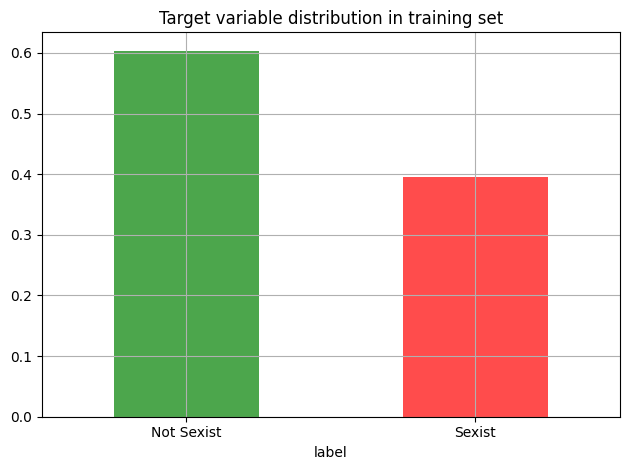

In [19]:
train.label.value_counts(normalize=True).plot(kind='bar', title='Target variable distribution in training set', color=['green', 'red'], alpha=0.7).set_xticklabels(['Not Sexist', 'Sexist'], rotation=0)
plt.grid()
plt.tight_layout()
plt.show()

# Task 2: Data Cleaning

>1. Remove emojis
>2. Remove hashtags (e.g. #metoo)
>3. Remove mentions (e.g. @user)
>4. Remove URLs
>5. Remove special characters and symbols
>6. Remove specific quote characters (e.g. curly quotes)
>7. Perform lemmatization

>**Bonus**: use other preprocessing strategies exploring techniques tailored specifically for tweets or methods that are common in social media text processing.

We slightly changed the order of the preprocessing to align more with the order followed by the GloVe preprocessing script tailored for tweets from Standford ([source](https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb)). This ensures that our preprocessing pipeline matches the one used to create the GloVe dataset, hopefully improving performances:  
1. Remove URLs  
2. Remove mentions  
3. Remove hashtags  
4. Remove special characters  
5. Remove specific quote characters  
6. Perform lemmatization  

We chose not to remove emojis, since the GloVe dataset we are using contains some emojis, and we did not want to lose that information. 

<div class="alert alert-info">
<b> Note: </b>The unknown emojis will be treated as normal out-of-vocabulary (OOV) tokens while the known emojis will be treated as normal words with their own embeddings.
</div>

To make comparisons later between original text and preprocessed text, we save a copy of the original dataset so we can print the preprocessed text next to the original one

In [20]:
original_train = train.copy()

Then we can apply all the preprocessing steps to the text as described above (in that order).

In [21]:
train['tweet'] = train['tweet'].apply(detector.preprocess_text)
val['tweet'] = val['tweet'].apply(detector.preprocess_text)
test['tweet'] = test['tweet'].apply(detector.preprocess_text)

### Perform lemmatization

The lemmatization is performed using the `nltk` library. 

<div class="alert alert-info">
<b> Note: </b> The `lemmatize` method is used to perform the lemmatization of the text. The lemmatization is performed on the cleaned text.
</div>

In [22]:
train['tweet'] = train['tweet'].apply(detector.lemmatize_text)
val['tweet'] = val['tweet'].apply(detector.lemmatize_text)
test['tweet'] = test['tweet'].apply(detector.lemmatize_text)

### Cast text to lowercase

The text is casted to lowercase to ensure that the model does not learn to distinguish between words based on the case of the letters (uncased).

In [23]:
train['tweet'] = train['tweet'].str.lower()
val['tweet'] = val['tweet'].str.lower()
test['tweet'] = test['tweet'].str.lower()

### Original and cleaned text

We can also inspect the difference between the original and cleaned text to see the effect of the preprocessing steps. As we can see the preprocessing steps have removed all the unwanted elements from the text and now the text is clean and ready to be used by the model.

<div class="alert alert-info">
<b>Note:</b> we substituted URL, mentions, and hashtags with the special tokens defined for GloVe. In this way, the model will have more information about the text and will not lose the information about the presence of URLs, mentions, and hashtags (which could be important for the classification of the text).
</div>

In [24]:
detector.text_diff(preprocessed_text=train, original_text=original_train, random=True)

Original tweet:
"protect women/children" in conservative jargon = controlling every aspect about women/children by the patriarchy."I'm doing it for the good of you" no thanks, would you kindly fuck off
Processed tweet:
protect woman child in conservative jargon controlling every aspect about woman child by the patriarchy i m doing it for the good of you no thanks would you kindly fuck off


# Task 3: Text Encoding

>* Embed words using GloVe embeddings.

### Embed words using GloVe embeddings

The pretrained GloVe embeddings are used to embed the words in the text. First, we download the GloVe embeddings using the `gensim` library. We choose an embedding dimension of $50$. The specific model we use is `glove-twitter-50`, which is trained on Twitter data. Our intuition is that this model will perform better on tweets than other models trained on different data due to the fact that the language used in tweets differs from that in other types of text. By leveraging the specific language used in tweets, we aim to improve the model's performance and also reduce the number of out-of-vocabulary words (a common issue when using pretrained embeddings).

---

The vocabulary of the `glove-twitter-50` model is very large and contains many words. However, we are only using a subset of the words in the vocabulary, as we are focusing on the words used in the tweets. Additionally, since we are not interested in backpropagating the gradients to the embeddings, the magnitude of the embedding will not cause computational issues.

In [25]:
emb_model = detector.load_glove(model_name='glove-twitter', embedding_dim=EMBEDDING_DIM)
print(f"Vocabulary size: {len(emb_model.key_to_index)}")

Vocabulary size: 1193514


We can now extract the two ordered dictionaries (`train_idx_to_word`, `train_word_to_idx`) as well as the set of words appearing in the training set.

In [26]:
train_idx_to_word, train_word_to_idx, train_word_listing = detector.get_vocab(train)

We can inspect how many words in the training set are not in the GloVe vocabulary.

This can be conveniente to assess the coverage of the GloVe embeddings on the training set. From our analysis we can see that the coverage using the GloVe embeddings model `glove-twitter` is better with respect to the model `glove-wiki-gigaword` which is trained on Wikipedia data. The actual difference is not so big (around 1%) but it can be important to have a good coverage of the embeddings on the training set. 

<div class="alert alert-warning">
<b>Moreover</b>, such statistics do not take into account any possible difference in the quality of the embeddings which can be important to have a good performance of the model. The 1% difference might not be so important but the spatial location of the words in the embedding space can be important to have a good performance of the model.
</div>

In [27]:
detector.get_oov_stats(emb_model, train_word_listing)

Total OOV terms: 768 (7.80%)


We can also inspect what are these OOV words to have an idea of the words that are not in the GloVe vocabulary.

In [28]:
list(detector.get_oov(emb_model, train_word_listing))[:10]

['sirmed',
 'sandworms',
 'hideousness',
 'namjoons',
 'indue',
 'yalcın',
 'recondition',
 'gcfems',
 'transgenderism',
 'insularity']

As we can see the words that are not in the GloVe vocabulary are mostly slang words that are not so common in the English language. Also, this list contains words written wrongly (typos). The model will not be able to learn the embeddings for these words and will have to rely on the embeddings of similar words which can affect the performance of the model.

---

Now, to deal with these OOV tokens, we initially considered assigning a random vector to them. However, this might not be the best approach, as the model would learn to distinguish between the OOV tokens and the other tokens based on the embeddings. This is undesirable because the OOV tokens are not inherently different from the other tokens in the vocabulary.

A more effective approach would be to extract the co-occurrence matrix from the training set and use it to generate embeddings for the OOV tokens. By defining a window size, we can extract the co-occurrence matrix and then use it to generate the embeddings for the OOV tokens. Whenever an OOV token is encountered, we can define its embedding vector as the average of the embeddings of the most frequent words that co-occur with the OOV token. This way, the embeddings for the OOV tokens will be similar to those of the words that frequently co-occur with them. The similarity is derived from the co-occurrence matrix and the average of the embedding vectors. Our intuition is that this approach will provide better embeddings for the OOV tokens and improve the model's performance since we will locate the embedding in the same space as the other words that frequently co-occur with the OOV tokens (thus in the same context/usage from a linguistic point of view).

This is the approach we will use to generate the embeddings for the OOV tokens. We will set the window size to 10 to extract the co-occurrence matrix and generate the embeddings for the OOV tokens.


In [30]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sbrodox/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [39]:
def remove_stopwords(text):
    filtered_tokens = [word for word in text.split(" ") if word.lower() not in stopwords.words("english")]
    return " ".join(filtered_tokens)

In [40]:
train_nostowords = train.copy()

In [41]:
train_nostowords["tweet"] = train["tweet"].apply(remove_stopwords)

In [43]:
train_idx_to_word_nostop, train_word_to_idx_nostop, train_word_listing_nostop = detector.get_vocab(train_nostowords)

In [47]:
co_occurrence_matrix = detector.co_occurrence_count(train_nostowords, train_idx_to_word_nostop, train_word_to_idx_nostop, window_size=10)
co_occurrence_df = detector.co_occurrence_dataframe(co_occurrence_matrix, train_idx_to_word_nostop)
co_occurrence_df.head()

100%|██████████| 2870/2870 [00:00<00:00, 3221.09it/s]


,writing,uni,essay,local,pub,coffee,random,old,man,keep,...,armor,dragoon,estinen,nike,coochie,mutuals,owns,grabs,lh,mandy
writing,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
uni,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
essay,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
local,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pub,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After computing the co-occurrence matrix we decided to combine the training set vocabulary with the GloVe vocabulary and generate the embedding vectors for the words in the training set that do not appear in the GloVe vocabulary. This is done to have a better coverage of the embeddings on the training set and to have a better performance of the model. The embeddings for the OOV tokens are generated using the co-occurrence matrix and the average of the embeddings of the most frequent words that co-occur with the OOV tokens.

In [48]:
emb_model_augmented = detector.get_augmented_vocab(emb_model, train_words=train_word_listing, co_occurrence_df=co_occurrence_df, save=True)

Saving vocab to data/vocab.json
Vocab saved!


Now we can just get all the vectors from the augmented GloVe and use them as embedding matrix for the model.

In [49]:
embedding_matrix = emb_model_augmented.vectors
print(f"Embedding matrix of {embedding_matrix.shape[0]} words, each of {embedding_matrix.shape[1]} dimensions")

Embedding matrix of 1194284 words, each of 50 dimensions


Before moving on the model definition we will first compute the class weights to deal with the class imbalance in the dataset. The class weights are computed using the `compute_class_weight` method from the `sklearn` library. The class weights are used to weight the loss function in order to give more importance to the minority class. This is important to have a better performance of the model and to deal with the class imbalance in the dataset. In this way the model will be aware of the class imbalance thus leading to a better f1 score.

In [50]:
class_weights_tensor = detector.get_class_weights(train, 'label')

class_weights_tensor

tensor([0.8280, 1.2621])

# Task 4: Model definition

> * Baseline: Implement a Bidirectional LSTM with a Dense layer on top.
> * Model 1: add an additional LSTM layer to the baseline model.

### Baseline: Implement a Bidirectional LSTM with a Dense layer on top

The baseline model is implemented using a Bidirectional LSTM with a Dense layer on top. The model is defined using the `torch.nn` module. The model consists of an embedding layer, a Bidirectional LSTM layer, and a Dense layer. We added a dropout layer to prevent overfitting just before the Dense layer.

The Embedding layer is called with the `from_pretrained` method to initialize the weights of the embedding layer with the GloVe embeddings. Such layer is then frozen to prevent the gradients from being backpropagated to the embeddings. This is done to keep the embeddings fixed and use them as features for the model. Experimentally we found that freezing the embeddings provides better results than fine-tuning them both from a computational point of view and from a performance point of view.

Moreover since the output of the LSTM layer is a sequence of hidden states, we need to extract the hidden state at the last time step to pass it to the Dense layer. This can be done in several ways:
- Extract the hidden state at the last time step using the hidden state of the LSTM layer.
- Use some pooling technique to extract a fixed-size representation of the sequence of hidden states regardless of the sequence length.
- Other techniques like concatenating the last hidden state of the forward and backward LSTMs.

<div class="alert alert-warning">
<b>We choose</b> to use the pooling technique to extract a fixed-size representation of the sequence of hidden states. In this case we used the average pooling with the intuition that the average of the hidden states can provide a global information about the sequence of hidden states. Experimentally we found that the average pooling provides better results than the concat-based approach as well as taking just the last hidden state of the LSTM.
<div>

In [51]:
class BaselineModel(torch.nn.Module):
    def __init__(self, embedding_model, detector, hidden_dim, output_dim: int = 1, lstm_layers: int = 1, dropout: float = 0.3):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim

        self.word_embeddings = torch.nn.Embedding.from_pretrained(
            embeddings=torch.from_numpy(embedding_model.vectors),
            freeze=True,
            padding_idx=embedding_model.get_index(detector.PAD_TOKEN)
        )
        self.lstm = torch.nn.LSTM(input_size=embedding_model.vector_size, hidden_size=hidden_dim, bidirectional=True, num_layers=lstm_layers, batch_first=True)
        self.fc = torch.nn.Linear(in_features=2 * hidden_dim, out_features=output_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, inputs):
        out = self.word_embeddings(inputs)
        out, (h_n, c_n) = self.lstm(out)
        out = torch.mean(out, dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Task 5: Training and Evaluation

> * Train **all** models on the train set.
> * Evaluate **all** models on the validation set.
> * Compute metrics on the validation set.
> * Pick **at least** three seeds for robust estimation.
> * Pick the **best** performing model according to the observed validation set performance.
> * Evaluate your models using macro F1-score.

Here there's the definition of the wrapper class, that will be used to instantiate all the networks required. 

<div class="alert alert-info">
<b> Note: </b>All the models will be trained on training data and evaluated on the validation data. We added also an evaluation on the test set just to have a better understanding of the model's performance. F1 macro score will be the metric used to evaluate the models.
</div>

In [55]:
class LSTM_network():
    def __init__(self, name: str, seed: int, detector: SexismDetector, embedding_model: gensim.models.keyedvectors.KeyedVectors, hidden_dim: int = 128, output_dim: int = 2, lstm_layers: int = 1, dropout: float = 0.5):
        self.name = name

        self.seed = seed
        self.__set_seed(seed)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.network = BaselineModel(embedding_model, detector, hidden_dim, output_dim, lstm_layers, dropout)
        self.network.to(device)
        self.detector = detector
        self.embedding_model = embedding_model
        self.history = None
        self.trained = False
        self.predictions = None
        self.labels = None
        # Clear the cache and perform garbage collection on initialization
        self.clear_cache()

    def __set_seed(self, seed):
        """
        Set the random seed for reproducibility.

        This method sets the seed for CUDA operations and NumPy to ensure that
        the results are reproducible. It also sets the CUBLAS workspace configuration
        to ensure deterministic results.

        Args:
            seed (int): The seed value to set for random number generation.
        """
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)

    def clear_cache(self):
        """
        Clears the cache for CUDA and performs garbage collection.

        This method uses PyTorch's `torch.cuda.empty_cache()` to release all unoccupied cached memory
        currently held by the CUDA memory allocator, making that memory available for other GPU applications.
        It also calls Python's garbage collector to free up any unreferenced memory in the system.

        Note:
            This method should be used with caution as it can affect the performance of your application
            by causing memory fragmentation.
        """
        with torch.no_grad():
            torch.cuda.empty_cache()

        gc.collect()

    def train(self, training_set: pd.DataFrame, validation_set: pd.DataFrame, test_set: pd.DataFrame, epochs: int, batch_size: int, lr: float, weight_decay: float, verbose=True):
        # Get the train and validation dataloader
        train_dloader = self.detector.get_dataloader(data=training_set,
                                                    embedding_model=self.embedding_model,
                                                    type="train",
                                                    batch_size=batch_size,
                                                    shuffle=True)

        val_dloader = self.detector.get_dataloader(data=validation_set,
                                                embedding_model=self.embedding_model,
                                                type="val",
                                                batch_size=validation_set.shape[0],
                                                shuffle=False)
        
        test_dloader = self.detector.get_dataloader(data=test_set,
                                                embedding_model=self.embedding_model,
                                                type="test",
                                                batch_size=test_set.shape[0],
                                                shuffle=False)


        # Initialize the history
        history = pd.DataFrame(columns=['model', 'epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc', 'learning_rate'])

        class_weights_tensor = self.detector.class_weights
        criterion = torch.nn.CrossEntropyLoss(
            weight=class_weights_tensor.to(device),
            ignore_index=self.embedding_model.get_index(self.detector.PAD_TOKEN)
        )

        optimizer = torch.optim.AdamW(self.network.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

        # Train if the model is not already saved
        if not Path.exists(detector.MODEL_FOLDER / f'{self.name}.pth'):
            # Initialize parameters for Early stopping
            best_val_loss = np.inf
            best_model = None
            best_model_epoch = 0
            best_f1_score = 0

            # Train the model
            for epoch in range(epochs):
                train_correct = 0
                train_total = 0
                grad_loss_vec = []

                # Training phase
                self.network.train()
                for batch in train_dloader:
                    sentences, labels = batch
                    sentences, labels = sentences.to(device), labels.to(device)

                    optimizer.zero_grad()
                    output = self.network(sentences)
                    loss = criterion(output, labels)
                    loss.backward()
                    optimizer.step()

                    predicted = torch.argmax(output, dim=1)
                    train_total += labels.size(0)
                    train_correct += (predicted == labels).sum().item()

                    # Save the gradients for the current batch
                    grad_loss_vec.append(loss.item())

                # Validation phase
                self.network.eval()
                final_val_loss = 0
                val_correct = 0
                val_total = 0
                val_predicted_arr = []
                val_labels_arr = []

                with torch.no_grad():
                    for batch in val_dloader:
                        sentence, labels = batch
                        sentence, labels = sentence.to(device), labels.to(device)

                        output = self.network(sentence)
                        val_loss = criterion(output, labels)
                        final_val_loss += val_loss.item()

                        predicted = torch.argmax(output, dim=1)
                        val_total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()

                        val_predicted_arr.append(predicted)
                        val_labels_arr.append(labels)

                val_predicted_arr = torch.cat(val_predicted_arr, dim=0).cpu().numpy()
                val_labels_arr = torch.cat(val_labels_arr, dim=0).cpu().numpy()

                f1 = f1_score(val_labels_arr, val_predicted_arr, average='macro')

                # Step the scheduler
                scheduler.step(final_val_loss)

                if final_val_loss < best_val_loss:
                    best_val_loss = final_val_loss
                    best_model = copy.deepcopy(self.network.state_dict())
                    best_model_epoch = epoch
                    best_f1_score = f1

                # Compute the mean loss for the epoch across all batches
                loss_value = np.mean(grad_loss_vec)

                if verbose:
                    print(f"Epoch {epoch + 1}/{epochs}\tLoss: {loss_value:.4f}\tAcc: {train_correct / train_total:.4f}\t"
                        f"Val Loss: {final_val_loss:.4f}\tVal Acc: {val_correct / val_total:.4f}\tmacro_f1: {f1:.4f}\t"
                        f"lr: {scheduler.get_last_lr()[0]:.7f}")

                history.loc[len(history)] = [self.name, epoch + 1, loss_value, final_val_loss, train_correct / train_total, val_correct / val_total, scheduler.get_last_lr()[0]]

            # Restore the best model
            self.network.load_state_dict(best_model)
            print(f"Best model found at epoch {best_model_epoch + 1} with validation loss: {best_val_loss:.4f} and f1 score: {best_f1_score:.4f}")

            # Compute metrics on validation set with the best model
            self.network.eval()
            val_predicted_arr = []
            val_labels_arr = []

            with torch.no_grad():
                for batch in val_dloader:
                    sentence, labels = batch
                    sentence, labels = sentence.to(device), labels.to(device)

                    output = self.network(sentence)
                    predicted = torch.argmax(output, dim=1)
                    val_predicted_arr.append(predicted)
                    val_labels_arr.append(labels)

            val_predicted_arr = torch.cat(val_predicted_arr, dim=0).cpu().numpy()
            val_labels_arr = torch.cat(val_labels_arr, dim=0).cpu().numpy()

            val_final_accuracy = accuracy_score(val_labels_arr, val_predicted_arr)
            val_final_f1 = f1_score(val_labels_arr, val_predicted_arr, average='macro')

            print(f"Validation set metrics on best model:\n"
                f"Accuracy: {val_final_accuracy:.4f}\tF1: {val_final_f1:.4f}")

            # Save the predictions on validation set
            self.val_predictions = val_predicted_arr
            self.val_labels = val_labels_arr

            # Save the metrics on the validation set
            self.val_accuracy = val_final_accuracy
            self.val_f1 = val_final_f1

            # Compute metrics on the test set with the best model
            self.network.eval()
            test_predicted_arr = []
            test_labels_arr = []

            with torch.no_grad():
                for batch in test_dloader:
                    sentence, labels = batch
                    sentence, labels = sentence.to(device), labels.to(device)

                    output = self.network(sentence)
                    predicted = torch.argmax(output, dim=1)
                    test_predicted_arr.append(predicted)
                    test_labels_arr.append(labels)

            test_predicted_arr = torch.cat(test_predicted_arr, dim=0).cpu().numpy()
            test_labels_arr = torch.cat(test_labels_arr, dim=0).cpu().numpy()

            test_final_accuracy = accuracy_score(test_labels_arr, test_predicted_arr)
            test_final_f1 = f1_score(test_labels_arr, test_predicted_arr, average='macro')

            print(f"Test set metrics on best model:\n"
                f"Accuracy: {test_final_accuracy:.4f}\tF1: {test_final_f1:.4f}")

            # Save the predictions on test set
            self.test_predictions = test_predicted_arr
            self.test_labels = test_labels_arr

            # Save the metrics on the test set
            self.test_accuracy = test_final_accuracy
            self.test_f1 = test_final_f1

            # Save the best model
            torch.save(self.network.state_dict(), detector.MODEL_FOLDER / f'{self.name}.pth')

            # Save the history and set the model as trained
            self.history = history
            self.trained = True

            # Dump the history to a CSV file for later analysis
            history.to_csv(detector.CSV_FOLDER / f'{self.name}_history.csv', index=False)

            return history

        # Otherwise, load the model and return the history
        else:
            # Load the model
            self.network.load_state_dict(torch.load(detector.MODEL_FOLDER / f'{self.name}.pth', weights_only=True))

            # Compute metrics on validation set with the best model
            self.network.eval()
            val_predicted_arr = []
            val_labels_arr = []

            with torch.no_grad():
                for batch in val_dloader:
                    sentence, labels = batch
                    sentence, labels = sentence.to(device), labels.to(device)

                    output = self.network(sentence)
                    predicted = torch.argmax(output, dim=1)
                    val_predicted_arr.append(predicted)
                    val_labels_arr.append(labels)

            val_predicted_arr = torch.cat(val_predicted_arr, dim=0).cpu().numpy()
            val_labels_arr = torch.cat(val_labels_arr, dim=0).cpu().numpy()

            val_final_accuracy = accuracy_score(val_labels_arr, val_predicted_arr)
            val_final_f1 = f1_score(val_labels_arr, val_predicted_arr, average='macro')

            print(f"Validation set metrics on best model:\n"
                f"Accuracy: {val_final_accuracy:.4f}\tF1: {val_final_f1:.4f}")

            # Save the predictions on validation set
            self.val_predictions = val_predicted_arr
            self.val_labels = val_labels_arr

            # Save the metrics on the validation set
            self.val_accuracy = val_final_accuracy
            self.val_f1 = val_final_f1

            # Compute metrics on the test set with the best model
            self.network.eval()
            test_predicted_arr = []
            test_labels_arr = []

            with torch.no_grad():
                for batch in test_dloader:
                    sentence, labels = batch
                    sentence, labels = sentence.to(device), labels.to(device)

                    output = self.network(sentence)
                    predicted = torch.argmax(output, dim=1)
                    test_predicted_arr.append(predicted)
                    test_labels_arr.append(labels)

            test_predicted_arr = torch.cat(test_predicted_arr, dim=0).cpu().numpy()
            test_labels_arr = torch.cat(test_labels_arr, dim=0).cpu().numpy()

            test_final_accuracy = accuracy_score(test_labels_arr, test_predicted_arr)
            test_final_f1 = f1_score(test_labels_arr, test_predicted_arr, average='macro')

            print(f"Test set metrics on best model:\n"
                f"Accuracy: {test_final_accuracy:.4f}\tF1: {test_final_f1:.4f}")

            # Save the predictions on test set
            self.test_predictions = test_predicted_arr
            self.test_labels = test_labels_arr

            # Save the metrics on the test set
            self.test_accuracy = test_final_accuracy
            self.test_f1 = test_final_f1

            # Load back the history and set the model as not trained
            self.history = pd.read_csv(detector.CSV_FOLDER / f'{self.name}_history.csv')
            self.trained = False

            return history

    def plot_history(self):
        if not self.trained:
            print("Model has not been trained. Showing the history of the last training session.\n")
            
        _, axes = plt.subplots(1, 3, figsize=(18, 5))
        baseline_model_name = self.history['model'] == self.name
        best_epoch = self.history[baseline_model_name]['val_loss'].idxmin()

        # Plot the history of the model
        ax = self.history[baseline_model_name].plot(x='epoch', y=['train_loss', 'val_loss'], title='Loss', ax=axes[0])
        # Highlight the best epoch in the plot and show it with a red dot on the graph + legend
        ax.scatter(best_epoch+1, self.history[baseline_model_name]['val_loss'].iloc[best_epoch], c='red', label='Best Epoch')
        # Annotations for the best epoch
        axes[0].annotate(f'Best Epoch: {best_epoch+1}', (best_epoch+1, self.history[baseline_model_name]['val_loss'].iloc[best_epoch]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

        # Plot the accuracy and learning rate
        ax = self.history[baseline_model_name].plot(x='epoch', y=['train_acc', 'val_acc'], title='Accuracy', ax=axes[1])
        self.history[baseline_model_name].plot(x='epoch', y='learning_rate', title='Learning Rate', ax=axes[2], logy=True)

        # Save the image inside the images folder
        if not detector.IMG_FOLDER.exists():
            detector.IMG_FOLDER.mkdir(parents=True)
            print(f"Created folder {detector.IMG_FOLDER}.")
        plt.savefig(detector.IMG_FOLDER / f'{self.name}_history.svg', format='svg')

        plt.tight_layout()
        plt.show()

# LSTMs

The idea here is to run three times the baseline model with different seeds and then average the performance over the seeds with the standard deviation. This is done to have a robust estimation of the performance of the model and to have a better idea of the performance of the model.

We will iterate over each seed, train the model (or load it back if already trained) and evaluate it on the validation set + the test set. We will then store the results in a dictionary which we will use later with the transformer models.

We also saved the history of the training to plot the loss and accuracy over the epochs in a CSV file.

The graphs of the loss and accuracy over the epochs are plotted below.

In [56]:
# Accumulate the results of each seed
lstm_results_df = pd.DataFrame(columns=['name', 'val_accuracy', 'val_f1', 'test_accuracy', 'test_f1', 'layers'])

Training baseline model with seed 1337
Epoch 1/60	Loss: 0.6916	Acc: 0.4526	Val Loss: 0.6855	Val Acc: 0.6582	macro_f1: 0.6502	lr: 0.0001000
Epoch 2/60	Loss: 0.6858	Acc: 0.6111	Val Loss: 0.6300	Val Acc: 0.5823	macro_f1: 0.5755	lr: 0.0001000
Epoch 3/60	Loss: 0.6618	Acc: 0.6268	Val Loss: 0.5868	Val Acc: 0.7025	macro_f1: 0.6787	lr: 0.0001000
Epoch 4/60	Loss: 0.6395	Acc: 0.6770	Val Loss: 0.5665	Val Acc: 0.7089	macro_f1: 0.7066	lr: 0.0001000
Epoch 5/60	Loss: 0.6104	Acc: 0.6976	Val Loss: 0.5926	Val Acc: 0.6899	macro_f1: 0.6805	lr: 0.0001000
Epoch 6/60	Loss: 0.5913	Acc: 0.6965	Val Loss: 0.5898	Val Acc: 0.7215	macro_f1: 0.7044	lr: 0.0001000
Epoch 7/60	Loss: 0.5869	Acc: 0.7070	Val Loss: 0.5419	Val Acc: 0.7468	macro_f1: 0.7442	lr: 0.0001000
Epoch 8/60	Loss: 0.5543	Acc: 0.7240	Val Loss: 0.5385	Val Acc: 0.7468	macro_f1: 0.7360	lr: 0.0001000
Epoch 9/60	Loss: 0.5464	Acc: 0.7453	Val Loss: 0.5317	Val Acc: 0.7468	macro_f1: 0.7386	lr: 0.0001000
Epoch 10/60	Loss: 0.5416	Acc: 0.7425	Val Loss: 0.5200	Val Acc

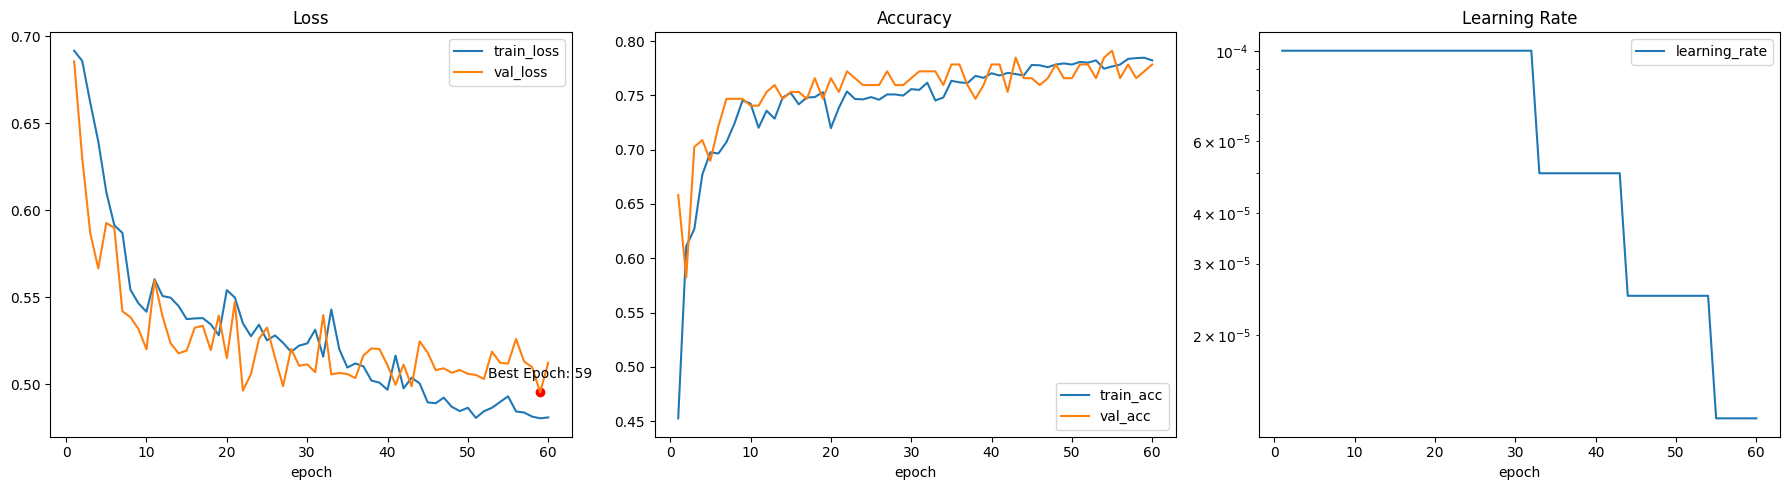

Training model with two LSTM layers with seed 1337
Epoch 1/60	Loss: 0.6923	Acc: 0.5282	Val Loss: 0.6848	Val Acc: 0.6392	macro_f1: 0.6074	lr: 0.0001000
Epoch 2/60	Loss: 0.6781	Acc: 0.5774	Val Loss: 0.6345	Val Acc: 0.6835	macro_f1: 0.6116	lr: 0.0001000
Epoch 3/60	Loss: 0.6560	Acc: 0.6554	Val Loss: 0.6210	Val Acc: 0.7152	macro_f1: 0.6726	lr: 0.0001000
Epoch 4/60	Loss: 0.6026	Acc: 0.7031	Val Loss: 0.5221	Val Acc: 0.7468	macro_f1: 0.7374	lr: 0.0001000
Epoch 5/60	Loss: 0.5984	Acc: 0.7024	Val Loss: 0.5679	Val Acc: 0.6582	macro_f1: 0.6562	lr: 0.0001000
Epoch 6/60	Loss: 0.5770	Acc: 0.7146	Val Loss: 0.5150	Val Acc: 0.7278	macro_f1: 0.7260	lr: 0.0001000
Epoch 7/60	Loss: 0.5787	Acc: 0.7111	Val Loss: 0.4973	Val Acc: 0.7658	macro_f1: 0.7608	lr: 0.0001000
Epoch 8/60	Loss: 0.5537	Acc: 0.7366	Val Loss: 0.5155	Val Acc: 0.7911	macro_f1: 0.7790	lr: 0.0001000
Epoch 9/60	Loss: 0.5507	Acc: 0.7289	Val Loss: 0.5000	Val Acc: 0.7405	macro_f1: 0.7397	lr: 0.0001000
Epoch 10/60	Loss: 0.5371	Acc: 0.7474	Val Loss: 0.

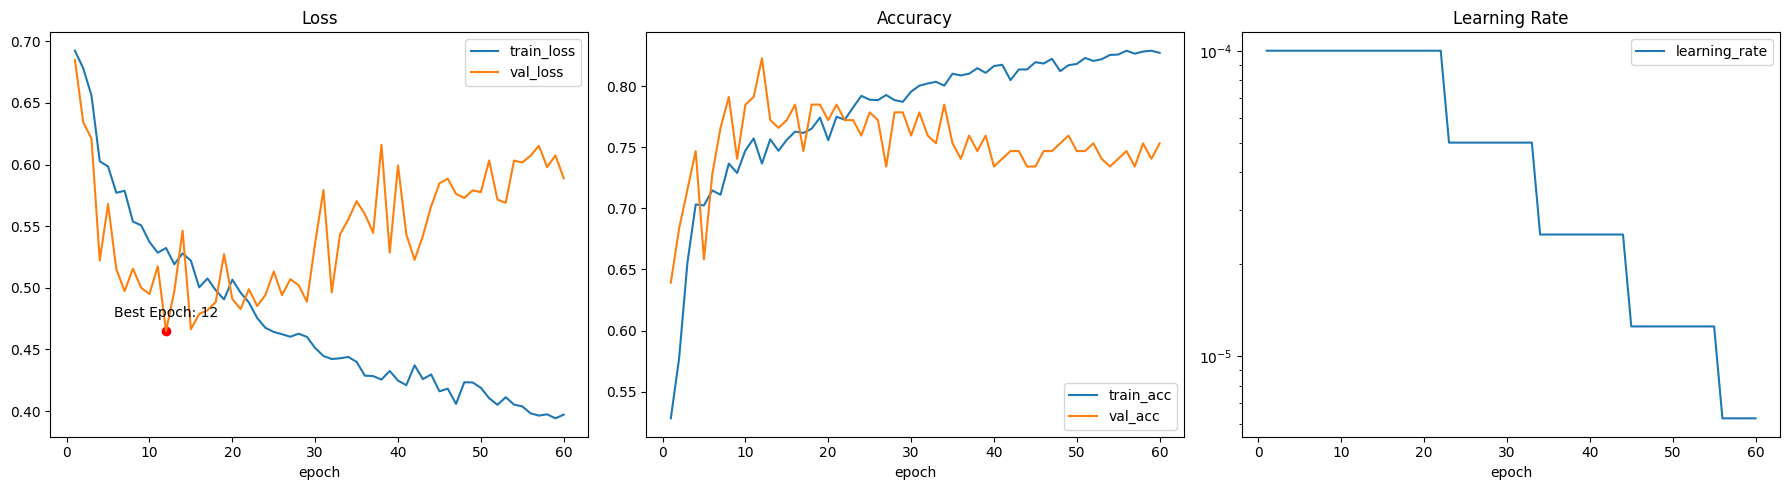

Training baseline model with seed 42
Epoch 1/60	Loss: 0.6927	Acc: 0.5098	Val Loss: 0.6865	Val Acc: 0.5506	macro_f1: 0.5246	lr: 0.0001000
Epoch 2/60	Loss: 0.6881	Acc: 0.5199	Val Loss: 0.6702	Val Acc: 0.6772	macro_f1: 0.6660	lr: 0.0001000
Epoch 3/60	Loss: 0.6657	Acc: 0.6233	Val Loss: 0.6580	Val Acc: 0.6582	macro_f1: 0.5911	lr: 0.0001000
Epoch 4/60	Loss: 0.6558	Acc: 0.6638	Val Loss: 0.6752	Val Acc: 0.6392	macro_f1: 0.5190	lr: 0.0001000
Epoch 5/60	Loss: 0.6485	Acc: 0.6868	Val Loss: 0.5925	Val Acc: 0.7215	macro_f1: 0.7111	lr: 0.0001000
Epoch 6/60	Loss: 0.6269	Acc: 0.6826	Val Loss: 0.5849	Val Acc: 0.7152	macro_f1: 0.7005	lr: 0.0001000
Epoch 7/60	Loss: 0.6398	Acc: 0.6826	Val Loss: 0.6540	Val Acc: 0.6646	macro_f1: 0.5910	lr: 0.0001000
Epoch 8/60	Loss: 0.6431	Acc: 0.6679	Val Loss: 0.5703	Val Acc: 0.7468	macro_f1: 0.7398	lr: 0.0001000
Epoch 9/60	Loss: 0.6242	Acc: 0.6909	Val Loss: 0.5556	Val Acc: 0.7025	macro_f1: 0.7016	lr: 0.0001000
Epoch 10/60	Loss: 0.6166	Acc: 0.6794	Val Loss: 0.5700	Val Acc: 

In [ ]:
for seed in seeds:
    # Baseline model
    print(f"Training baseline model with seed {seed}")
    lstm = LSTM_network(f"baseline_{seed}",
                        seed,
                        detector,
                        emb_model_augmented,
                        hidden_dim=HIDDEN_DIM,
                        output_dim=2,
                        lstm_layers=1,
                        dropout=0.4)

    history = lstm.train(train, val, test, EPOCHS, BATCH_SIZE, LEARNING_RATE, weight_decay=1e-5, verbose=True)

    # Save the predictions and labels inside the dict
    predictions_dict[lstm.name] = {'val': {}, 'test': {}}
    predictions_dict[lstm.name]['val'] = {'predictions': lstm.val_predictions, 'labels': lstm.val_labels}
    predictions_dict[lstm.name]['test'] = {'predictions': lstm.test_predictions, 'labels': lstm.test_labels}

    lstm.plot_history()

    lstm_results_df.loc[len(lstm_results_df)] = [lstm.name, lstm.val_accuracy, lstm.val_f1, lstm.test_accuracy, lstm.test_f1,  lstm.network.lstm_layers]

    # Clean up the cache and perform garbage collection
    with torch.no_grad():
        torch.cuda.empty_cache()

    gc.collect()

    # Model with two LSTM layers
    print(f"Training model with two LSTM layers with seed {seed}")
    lstm_2_layers = LSTM_network(f"2_layers_{seed}",
                                 seed,
                                 detector,
                                 emb_model_augmented,
                                 hidden_dim=HIDDEN_DIM,
                                 output_dim=2,
                                 lstm_layers=2,
                                 dropout=0.4)

    history = lstm_2_layers.train(train, val, test, EPOCHS, BATCH_SIZE, LEARNING_RATE, weight_decay=1e-5, verbose=True)

    # Save the predictions and labels inside the dict
    predictions_dict[lstm_2_layers.name] = {'val': {}, 'test': {}}
    predictions_dict[lstm_2_layers.name]['val'] = {'predictions': lstm_2_layers.val_predictions, 'labels': lstm_2_layers.val_labels}
    predictions_dict[lstm_2_layers.name]['test'] = {'predictions': lstm_2_layers.test_predictions, 'labels': lstm_2_layers.test_labels}

    lstm_2_layers.plot_history()

    lstm_results_df.loc[len(lstm_results_df)] = [lstm_2_layers.name, lstm_2_layers.val_accuracy, lstm_2_layers.val_f1, lstm_2_layers.test_accuracy, lstm_2_layers.test_f1,  lstm_2_layers.network.lstm_layers]

    # Clean up the cache and perform garbage collection
    with torch.no_grad():
        torch.cuda.empty_cache()

    gc.collect()

The above charts show the loss and accuracy over the epochs for the three seeds and for both the 1 layer as well as the two layer LSTM models. Training and validation loss is shown in the first chart, while training and validation accuracy is shown in the second chart. Last chart accounts for the dynamic learning rate scheduler and thus shows when the learning rate was decreased due to the lack of improvement in the validation loss (plateau). Best epoch is also annotated in the charts (early stopping) and clearly shows that the model is not overfitting the training data.

Talking about trends in these charts, we can see that 1 layer LSTM has a better convergence while the 2 layer LSTM has a better performance but starts to diverge after a certain number of epochs. This is due to the fact that the 2 layer LSTM has more parameters and is more complex than the 1 layer LSTM. The 2 layer LSTM is able to learn more complex patterns in the data but it is also more prone to overfitting even if we added a dropout layer. 

<div class="alert alert-info">
<b> Note: </b> There is no need to worry for such divergence since we are using early stopping and the model will stop training when the validation loss stops decreasing. At the end we are loading back the best model and we are evaluating it on the validation and test set.
</div>

Now we can get the mean and the standard deviation of the performance of the model over the seeds. This is done to have a better idea of the performance of the model and to have a robust estimation of the performance of the model.

In [38]:
lstm_results_df

,name,val_accuracy,val_f1,test_accuracy,test_f1,layers
0,baseline_1337,0.753165,0.750920,0.692308,0.691569,1
1,2_layers_1337,0.810127,0.803970,0.688811,0.688807,2
2,baseline_42,0.772152,0.766771,0.699301,0.699301,1
3,2_layers_42,0.816456,0.812482,0.664336,0.663282,2
4,baseline_69,0.778481,0.771818,0.671329,0.670749,1
5,2_layers_69,0.803797,0.799550,0.678322,0.678180,2


In [39]:
lstm_results_df_index = lstm_results_df.set_index('name')
print('Results for the baseline model:')
lstm_results_df_index[lstm_results_df_index['layers'] == 1].agg(['mean', 'std']).drop(columns='layers')

Results for the baseline model:


,val_accuracy,val_f1,test_accuracy,test_f1
mean,0.767932,0.763169,0.687646,0.687206
std,0.013175,0.010905,0.014557,0.014767


In [40]:
print('Results for the model with two LSTM layers:')
lstm_results_df_index[lstm_results_df_index['layers'] == 2].agg(['mean', 'std']).drop(columns='layers')

Results for the model with two LSTM layers:


,val_accuracy,val_f1,test_accuracy,test_f1
mean,0.810127,0.805334,0.677156,0.676756
std,0.006329,0.006573,0.012279,0.012822


As we can see the 2-layer LSTM model has a better performance than the 1-layer LSTM model and the standard deviation is also lower for the validation set. This means that the 2-layer LSTM model is more stable and has a better performance than the 1-layer LSTM model.

We will then extract the best model according to the f1 macro score on the validation set as required by the task.

In [41]:
# Model with best f1 score (macro)

best_model_name = lstm_results_df_index['val_f1'].idxmax()
print(f"Best model: {best_model_name} with f1 score: {lstm_results_df_index.loc[best_model_name, 'val_f1']:.4f}")

Best model: 2_layers_42 with f1 score: 0.8125


# Task 6: Transformers

In this section we will use a transformer model to perform the classification task. We will use the `Twitter-RoBERTa-base-hate` (https://huggingface.co/cardiffnlp/twitter-roberta-base-hate) model from the Hugging Face library. This model is trained on Twitter data and is fine-tuned for hate speech detection. We will use this model to perform the classification task and evaluate its performance.

Before moving on to the model definition, we slightly modify the Trainer class to be able to put the class weights in the training loop so that the loss is weighted according to the class weights. This is important to deal with the class imbalance in the dataset and to have a better performance of the model.

<div class="alert alert-info">
<b> Note: </b> we did not find any argument in the Trainer class to pass the class weights to the training loop so we had to inherit the Trainer class and modify the loss function part to be able to pass the class weights to the training loop.
</div>

In [42]:
# Since we know that there is a slightly imbalance in the dataset labels, instead of using the default Trainer class of HuggingFace, we can write a custom class inheriting from the Trainer class and override the `compute_loss` method to compute the loss with the class weights computed from the dataset labels. In this way the loss function will take into account the imbalance in the dataset labels and will give more importance to the minority class. The impact of this change is that the F1 and accuracy scores will be more similar to each other since the model will be trained to give more importance to the minority class w.r.t. the majority class.

# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, class_weights, device, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # You pass the class weights when instantiating the Trainer
        self.class_weights = class_weights
        self.device = device

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We extract the logits from the model outputs
            logits = outputs.get('logits')
            # We compute the loss manually passing the class weights to the loss function
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(self.device)) # Modified to use the class weights
            # We compute the loss using the modified criterion
            loss = criterion(logits, inputs['labels'])

        return (loss, outputs) if return_outputs else loss

Then we extracted the train, val and test sets from the pandas dataframe and created the datasets.

We specified the model card and the tokenizer to use for the model as well as the data collator to use for the model.

Since we are using the cleaned data our preprocessing is minimal and we only need to tokenize the text and convert the labels to integers.

In [43]:
# Get the train, val and test datasets
train_data = Dataset.from_pandas(train)
val_data = Dataset.from_pandas(val)
test_data = Dataset.from_pandas(test)

# Define the model card
model_card = 'cardiffnlp/twitter-roberta-base-hate'

# Get the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_card, use_Fast=False)

def preprocess_text(texts):
    return tokenizer(texts['tweet'])

# Select the right column
train_data = train_data.map(preprocess_text, batched=True)
val_data = val_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)

# Get the data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

We also defined a function to compute the metrics for the model. This function computes the f1 macro score as well as the accuracy.

In [44]:
def compute_metrics(output_info):
        """
        Compute various evaluation metrics for model predictions.

        Args:
            output_info (tuple): A tuple containing the model predictions and the true labels.
                - predictions (np.ndarray): The predicted labels from the model.
                - labels (np.ndarray): The true labels.

        Returns:
            dict: A dictionary containing the computed metrics:
                - 'f1': The F1 score (macro average).
                - 'accuracy': The accuracy score.
                - 'precision': The precision score (macro average).
                - 'recall': The recall score (macro average).
        """
        predictions, labels = output_info
        predictions = np.array(predictions)
        labels = np.array(labels)
        predictions = np.argmax(predictions, axis=-1)

        f1 = f1_score(labels, predictions, average="macro")
        acc = accuracy_score(labels, predictions)

        return {"f1-score" : f1, "Accuracy" : acc}

Now we can define the model and the training loop for the model. 

We will train the model for 6 epochs and evaluate it on the validation and test set. We will also save the best model based on the f1 macro score on the test set.

<div class="alert alert-info">
<b> Note: </b>To speedup the entire process we uploaded the model into Hugging Face repository and we will load it from there (if available) to avoid retraining the model every time we run the notebook. The training history is still available in the Hugging Face page of each of the models.
</div>

In [45]:
def twitter_roberta_base(model_card: str, seed: int, class_weights: torch.Tensor, train_data: Dataset, val_data: Dataset, test_data: Dataset, data_collator, device: torch.device):

    # Set the flag to False
    already_fine_tuned = False

    # Get model name
    model_name = model_card.split('/')[-1]

    # Clear the cache and perform garbage collection
    with torch.no_grad():
        torch.cuda.empty_cache()

    gc.collect()

    # Try to fetch the model from the HuggingFace Hub (if it exists)
    try:
        # Model already fine-tuned
        model = AutoModelForSequenceClassification.from_pretrained(f'MatteoFasulo/{model_name}_{seed}', num_labels=2, id2label={0: 'NEG', 1: 'POS'}, label2id={'NEG': 0, 'POS': 1})
        already_fine_tuned = True

    except:
        model = AutoModelForSequenceClassification.from_pretrained(model_card, num_labels=2, id2label={0: 'NEG', 1: 'POS'}, label2id={'NEG': 0, 'POS': 1})

    # Get the training arguments
    training_args = TrainingArguments(
        output_dir=f'{model_name}_{seed}',                 # where to save model
        learning_rate=ROBERTA_LEARNING_RATE,
        per_device_train_batch_size=ROBERTA_BATCH_SIZE,         # accelerate defines distributed training
        per_device_eval_batch_size=ROBERTA_BATCH_SIZE,
        num_train_epochs=ROBERTA_EPOCHS,
        weight_decay=1e-5,
        eval_strategy="epoch",           # when to report evaluation metrics/losses
        save_strategy="epoch",                 # when to save checkpoint
        save_safetensors=True,           # save model with safe tensors
        load_best_model_at_end=True,
        report_to='none',                    # disabling wandb (default)
        seed=seed,
        data_seed=seed
    )

    # Get the trainer
    trainer = CustomTrainer(
                model=model,
                args=training_args,
                train_dataset=train_data,
                eval_dataset=test_data,
                data_collator=data_collator,
                compute_metrics=compute_metrics,
                class_weights=class_weights,
                device=device,
            )

    if not already_fine_tuned:
        # Train the model
        trainer.train()

    # Get the predictions for the validation set
    val_predictions_info = trainer.predict(val_data)
    val_predictions, val_labels = val_predictions_info.predictions, val_predictions_info.label_ids

    # Transpose the predictions and get the argmax
    val_predictions = np.argmax(val_predictions, axis=1)

    # Get the predictions for the test set
    test_predictions_info = trainer.predict(test_data)
    test_predictions, test_labels = test_predictions_info.predictions, test_predictions_info.label_ids

    # Transpose the predictions and get the argmax
    test_predictions = np.argmax(test_predictions, axis=1)

    # Update the predictions dict with the new predictions
    predictions_dict[f'{model_name}_{seed}'] = {'val': {}, 'test': {}}
    predictions_dict[f'{model_name}_{seed}']['val'] = {'predictions': val_predictions, 'labels': val_labels}
    predictions_dict[f'{model_name}_{seed}']['test'] = {'predictions': test_predictions, 'labels': test_labels}

    print(f"Validation set metrics for model {model_name}_{seed}:\n{val_predictions_info.metrics}\n")
    print(f"Test set metrics for model {model_name}_{seed}:\n{test_predictions_info.metrics}\n")

    if not already_fine_tuned:
        # Push the model to HuggingFace Hub
        trainer.push_to_hub()

### Twitter roBERTa base hate model with seed 1337

The first model we will train is the Twitter roBERTa base hate model with seed 1337. At the end of the training we will evaluate the model on the test set and compute the metrics for the model. In case this is the first time the model is trained, the model will be trained and saved in the Hugging Face repository. Otherwise, the model will be loaded from the Hugging Face repository and evaluated on the test set.

In [46]:
twitter_roberta_base(
    model_card = model_card,
    seed = 1337,
    class_weights = class_weights_tensor,
    train_data = train_data,
    val_data= val_data,
    test_data = test_data,
    data_collator = data_collator,
    device=device
)

Validation set metrics for model twitter-roberta-base-hate_1337:
{'test_loss': 0.4069879353046417, 'test_model_preparation_time': 0.0057, 'test_f1-score': 0.8949468085106382, 'test_Accuracy': 0.8987341772151899, 'test_runtime': 0.3653, 'test_samples_per_second': 432.55, 'test_steps_per_second': 27.377}

Test set metrics for model twitter-roberta-base-hate_1337:
{'test_loss': 0.3619557023048401, 'test_model_preparation_time': 0.0057, 'test_f1-score': 0.8521053927604039, 'test_Accuracy': 0.8531468531468531, 'test_runtime': 0.4484, 'test_samples_per_second': 637.866, 'test_steps_per_second': 40.145}



the same applies to the other seeds

### Twitter roBERTa base hate model with seed 42

In [47]:
twitter_roberta_base(
    model_card = model_card,
    seed = 42,
    class_weights = class_weights_tensor,
    train_data = train_data,
    val_data= val_data,
    test_data = test_data,
    data_collator = data_collator,
    device=device
)

Validation set metrics for model twitter-roberta-base-hate_42:
{'test_loss': 0.384492427110672, 'test_model_preparation_time': 0.0057, 'test_f1-score': 0.8818151595744681, 'test_Accuracy': 0.8860759493670886, 'test_runtime': 0.2628, 'test_samples_per_second': 601.109, 'test_steps_per_second': 38.045}

Test set metrics for model twitter-roberta-base-hate_42:
{'test_loss': 0.3668936491012573, 'test_model_preparation_time': 0.0057, 'test_f1-score': 0.8311688311688312, 'test_Accuracy': 0.8321678321678322, 'test_runtime': 0.442, 'test_samples_per_second': 647.108, 'test_steps_per_second': 40.727}



### Twitter roBERTa base hate model with seed 69

In [48]:
twitter_roberta_base(
    model_card = model_card,
    seed = 69,
    class_weights = class_weights_tensor,
    train_data = train_data,
    val_data= val_data,
    test_data = test_data,
    data_collator = data_collator,
    device=device
)

Validation set metrics for model twitter-roberta-base-hate_69:
{'test_loss': 0.38436391949653625, 'test_model_preparation_time': 0.0058, 'test_f1-score': 0.8686835106382979, 'test_Accuracy': 0.8734177215189873, 'test_runtime': 0.2644, 'test_samples_per_second': 597.549, 'test_steps_per_second': 37.82}

Test set metrics for model twitter-roberta-base-hate_69:
{'test_loss': 0.3647672235965729, 'test_model_preparation_time': 0.0058, 'test_f1-score': 0.8345946078974246, 'test_Accuracy': 0.8356643356643356, 'test_runtime': 0.4427, 'test_samples_per_second': 646.081, 'test_steps_per_second': 40.662}



# Task 7: Error Analysis

In this section we will perform an error analysis of the models. We will analyze the errors made by the models and try to understand why the models are making these errors.

We defined a class to perform the error analysis of the models. The class contains methods to perform the error analysis of the models and to plot the results of the error analysis. The class implements a method to aggregate all the predictions of the models (across seeds) and to compute the metrics for the aggregated predictions. The class also implements a method to plot the confusion matrix of the aggregated predictions.

The method to aggreagate the predictions is quite straightforward. We just take the majority vote of the predictions of the models (across seeds) and use it as the final prediction. This is done to have a better estimation of the performance of the model and to have a better idea of the performance of the model.

In [53]:
class Metrics:
    def __init__(self, predictions_dict: dict):
        self.predictions_dict = predictions_dict
        self.models = list(predictions_dict.keys())
        self.ensembled_dict = {}

    def majority_voting(self):
        """
        Apply majority voting to the given predictions.

        Args:
            predictions (np.ndarray): The predictions to be aggregated.

        Returns:
            np.ndarray: The aggregated predictions based on majority voting.
        """
        baseline_models = [model for model in self.models if model.startswith('baseline')]
        two_lstms = [model for model in self.models if model.startswith('2_layers')]
        roberta_models = [model for model in self.models if model.startswith('twitter')]
        xlm_models = [model for model in self.models if model.startswith('xlm')]

        threshold = len(baseline_models) // 2 + 1

        # Stack vertically the predictions of the models
        try:
            # Get the predictions for the validation set
            baseline_val_predictions = np.vstack([self.predictions_dict[model]['val']['predictions'] for model in baseline_models])
            # Initialize the dictionary for the ensembled predictions
            self.ensembled_dict['baseline'] = {'val': {}, 'test': {}}
            # Sum the predictions for each class
            val_colsum = np.sum(baseline_val_predictions, axis=0)
            # Apply majority voting
            val_majority_voting = (val_colsum >= threshold).astype(int)
            # Save the ensembled predictions
            self.ensembled_dict['baseline']['val'] = {'predictions': val_majority_voting, 'labels': self.predictions_dict[baseline_models[0]]['val']['labels']}
            # Get the predictions for the test set
            baseline_test_predictions = np.vstack([self.predictions_dict[model]['test']['predictions'] for model in baseline_models])
            # Sum the predictions for each class
            test_colsum = np.sum(baseline_test_predictions, axis=0)
            # Apply majority voting
            test_majority_voting = (test_colsum >= threshold).astype(int)
            # Save the ensembled predictions
            self.ensembled_dict['baseline']['test'] = {'predictions': test_majority_voting, 'labels': self.predictions_dict[baseline_models[0]]['test']['labels']}
        except ValueError: # Models not trained
            pass

        try:
            two_lstm_val_predictions = np.vstack([self.predictions_dict[model]['val']['predictions'] for model in two_lstms])
            self.ensembled_dict['2_layers'] = {'val': {}, 'test': {}}
            val_colsum = np.sum(two_lstm_val_predictions, axis=0)
            val_majority_voting = (val_colsum >= threshold).astype(int)
            self.ensembled_dict['2_layers']['val'] = {'predictions': val_majority_voting, 'labels': self.predictions_dict[two_lstms[0]]['val']['labels']}
            two_lstm_test_predictions = np.vstack([self.predictions_dict[model]['test']['predictions'] for model in two_lstms])
            test_colsum = np.sum(two_lstm_test_predictions, axis=0)
            test_majority_voting = (test_colsum >= threshold).astype(int)
            self.ensembled_dict['2_layers']['test'] = {'predictions': test_majority_voting, 'labels': self.predictions_dict[two_lstms[0]]['test']['labels']}
        except ValueError: # Models not trained
            pass

        try:
            roberta_val_predictions = np.vstack([self.predictions_dict[model]['val']['predictions'] for model in roberta_models])
            self.ensembled_dict['twitter'] = {'val': {}, 'test': {}}
            val_colsum = np.sum(roberta_val_predictions, axis=0)
            val_majority_voting = (val_colsum >= threshold).astype(int)
            self.ensembled_dict['twitter']['val'] = {'predictions': val_majority_voting, 'labels': self.predictions_dict[roberta_models[0]]['val']['labels']}
            roberta_test_predictions = np.vstack([self.predictions_dict[model]['test']['predictions'] for model in roberta_models])
            test_colsum = np.sum(roberta_test_predictions, axis=0)
            test_majority_voting = (test_colsum >= threshold).astype(int)
            self.ensembled_dict['twitter']['test'] = {'predictions': test_majority_voting, 'labels': self.predictions_dict[roberta_models[0]]['test']['labels']}
        except ValueError: # Models not trained
            pass

        try:
            xlm_val_predictions = np.vstack([self.predictions_dict[model]['val']['predictions'] for model in xlm_models])
            self.ensembled_dict['xlm'] = {'val': {}, 'test': {}}
            val_colsum = np.sum(xlm_val_predictions, axis=0)
            val_majority_voting = (val_colsum >= threshold).astype(int)
            self.ensembled_dict['xlm']['val'] = {'predictions': val_majority_voting, 'labels': self.predictions_dict[xlm_models[0]]['val']['labels']}
            xlm_test_predictions = np.vstack([self.predictions_dict[model]['test']['predictions'] for model in xlm_models])
            test_colsum = np.sum(xlm_test_predictions, axis=0)
            test_majority_voting = (test_colsum >= threshold).astype(int)
            self.ensembled_dict['xlm']['test'] = {'predictions': test_majority_voting, 'labels': self.predictions_dict[xlm_models[0]]['test']['labels']}
        except ValueError: # Models not trained
            pass


    def get_confusion_matrix(self, predictions: np.ndarray, labels: np.ndarray, title: str, ax=None):
        """
        Generates and displays a confusion matrix for the given predictions and labels.

        Args:
            predictions (numpy.ndarray): The predicted probabilities or logits for each class.
            labels (numpy.ndarray): The true labels for the data.

        Returns:
            None: This function displays the confusion matrix plot and does not return any value.
        """
        cm = confusion_matrix(y_true=labels, y_pred=predictions)
        display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-sexist', 'Sexist']).plot(cmap='viridis', ax=ax)
        _ = display.ax_.set_title(title)
        plt.savefig(detector.IMG_FOLDER / f'{title}.svg', format='svg')

    def get_precision_recall(self, predictions: np.ndarray, labels: np.ndarray, model_name: str, plot_title: str, ax=None):
        """
        Calculate and display the precision-recall curve for the given predictions and labels.

        Args:
            predictions (np.ndarray): The predicted probabilities or logits from the model.
            labels (np.ndarray): The true labels for the data.

        Returns:
            None: This function displays the precision-recall curve using matplotlib.
        """
        display = PrecisionRecallDisplay.from_predictions(y_true=labels, y_pred=predictions, name=model_name, plot_chance_level=True, ax=ax)
        _ = display.ax_.set_title(plot_title)
        plt.savefig(detector.IMG_FOLDER / f'{plot_title}.svg', format='svg')

    def get_f1_score(self, predictions: np.ndarray, labels: np.ndarray):
        """
        Calculate the F1 score for the given predictions and labels.

        Args:
            predictions (np.ndarray): The predicted probabilities or logits from the model.
            labels (np.ndarray): The true labels for the data.

        Returns:
            float: The F1 score for the model predictions.
        """
        return f1_score(y_true=labels, y_pred=predictions, average='macro')

    def contains_OOV(self, text: str, tokenizer: AutoTokenizer):
        """
        Return the out-of-vocabulary (OOV) words in a given text.
        """
        vocab_words = list(tokenizer.vocab.keys())
        return set(word for word in text.split() if word not in vocab_words)

    def review_errors(self, preprocessed_data, predictions, labels, tokenizer: AutoTokenizer, verbose: bool = False):
        """
        Analyzes and reviews errors in model predictions.

        Args:
            original_data (pd.DataFrame): The original dataset containing the true labels.
            preprocessed_data (pd.DataFrame): The preprocessed dataset used for predictions.
            predictions (np.ndarray): The model's predictions.
            labels (np.ndarray): The true labels.
            verbose (bool, optional): If True, prints detailed information about each error. Defaults to False.

        Returns:
            list: A list of tweet IDs where the model made incorrect predictions.

        Prints:
            - The total number of errors found.
            - Detailed information about each error if verbose is True.
            - The number and percentage of errors due to Out-Of-Vocabulary (OOV) words.
        """
        # Store the missclassified samples
        errors = []
        for i, (pred, label) in enumerate(zip(predictions, labels)):
            if pred != label: # If the prediction is incorrect
                errors.append(i) # Store the index of the error

        # Store the number of errors due to OOV words
        errors_due_to_OOV = 0
        # Store the ID of the wrong predictions
        wrong_predictions = []
        # Iterate over the errors
        for i in errors:
            # Get the tweet text
            tweet_text = preprocessed_data['tweet'][i]
            # Get the tweet ID of the error
            exist_id = preprocessed_data['id_EXIST'][i]
            # Append the ID to the wrong predictions list
            wrong_predictions.append(exist_id)
            # Check if the tweet contains OOV words
            oov_found = self.contains_OOV(tweet_text, tokenizer)
            # Remove from the set of OOV words the special tokens
            oov_found = [word for word in oov_found if not word.startswith('<') and not word.endswith('>')]
            if len(oov_found) > 0:
                errors_due_to_OOV += 1
            if verbose:
                print(f"""
                Contains OOV: {oov_found if len(oov_found) > 0 else 'No'}
                Tweet: {tweet_text}
                Predicted: {predictions[i]}
                True Label: {labels[i]}
                """)
        print(f"Errors due to OOV: {errors_due_to_OOV}, {errors_due_to_OOV / len(errors) * 100:.2f}%\n")
        return wrong_predictions

We will make subplots each with the confusion matrix of the aggregated models as well as the precision-recall curve of the aggregated models.

To have better insights on the errors made by the model we will also print the tweets that are misclassified by the model. In this way we can see if the missclassified tweet contains any OOV words or if the model is making the error for some other reason.

In [54]:
metrics = Metrics(predictions_dict=predictions_dict)

# Get the ensemble predictions
metrics.majority_voting()

### Metrics of the ensembled models

In [55]:
# Calculate the F1 score for each of the ensembled models
f1_scores_ensembled = {model_name: metrics.get_f1_score(metrics.ensembled_dict[model_name]['val']['predictions'], metrics.ensembled_dict[model_name]['val']['labels']) for model_name in metrics.ensembled_dict.keys()}
accuracy_ensembled = {model_name: accuracy_score(metrics.ensembled_dict[model_name]['val']['labels'], metrics.ensembled_dict[model_name]['val']['predictions']) for model_name in metrics.ensembled_dict.keys()}
print(f"F1 for the validation set of ensembled models: {f1_scores_ensembled}")
print(f"Accuracy for the validation set of ensembled models: {accuracy_ensembled}")

F1 for the validation set of ensembled models: {'baseline': 0.7805555555555556, '2_layers': 0.8117424709314269, 'twitter': 0.8818151595744681}
Accuracy for the validation set of ensembled models: {'baseline': 0.7848101265822784, '2_layers': 0.8164556962025317, 'twitter': 0.8860759493670886}


In [56]:
# Calculate the F1 score for each of the ensembled models
f1_scores_ensembled = {model_name: metrics.get_f1_score(metrics.ensembled_dict[model_name]['test']['predictions'], metrics.ensembled_dict[model_name]['test']['labels']) for model_name in metrics.ensembled_dict.keys()}
accuracy_ensembled = {model_name: accuracy_score(metrics.ensembled_dict[model_name]['test']['labels'], metrics.ensembled_dict[model_name]['test']['predictions']) for model_name in metrics.ensembled_dict.keys()}
print(f"F1 for the test set of ensembled models: {f1_scores_ensembled}")
print(f"Accuracy for the test set of ensembled models: {accuracy_ensembled}")

F1 for the test set of ensembled models: {'baseline': 0.6990652376058337, '2_layers': 0.6747257585207469, 'twitter': 0.8414458365672469}
Accuracy for the test set of ensembled models: {'baseline': 0.6993006993006993, '2_layers': 0.6748251748251748, 'twitter': 0.8426573426573427}


### Validation Set

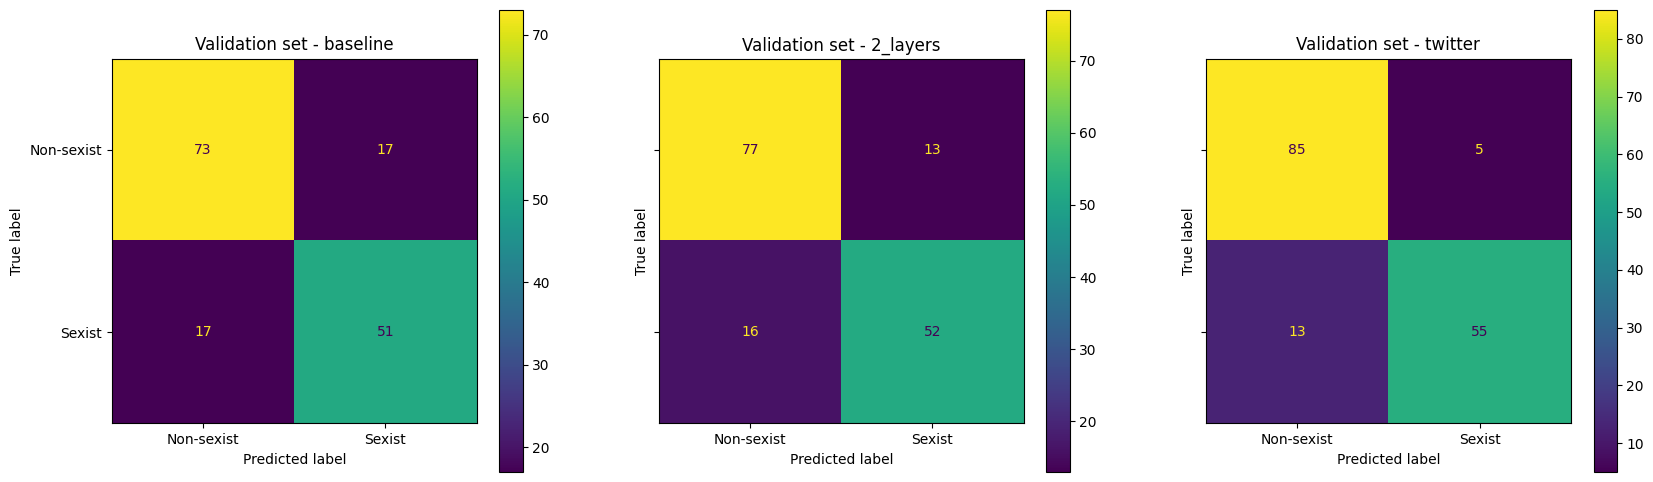

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot the confusion matrix for each of the models Cardiff Twitter RoBERTa Base on the validation set
for i, model_name in enumerate(list(metrics.ensembled_dict.keys())):
    predictions = metrics.ensembled_dict[model_name]['val']['predictions']
    labels = metrics.ensembled_dict[model_name]['val']['labels']
    metrics.get_confusion_matrix(predictions, labels, title=f"Validation set - {model_name}", ax=ax[i])

From the confusion matrix we can see that:
- the baseline LSTM model missclassifies equally both the sexist and non-sexist tweets
- the two layer LSTM model has a better performance than the baseline model but still missclassifies some tweets. In this case the model fails more on detecting real sexist tweets annotating them as non-sexist (bottom left corner of the confusion matrix)
- the transformer model has a better performance than the LSTM models but shows the same pattern of the two layer LSTM model. It missclassifies more sexist tweets than non-sexist tweets.

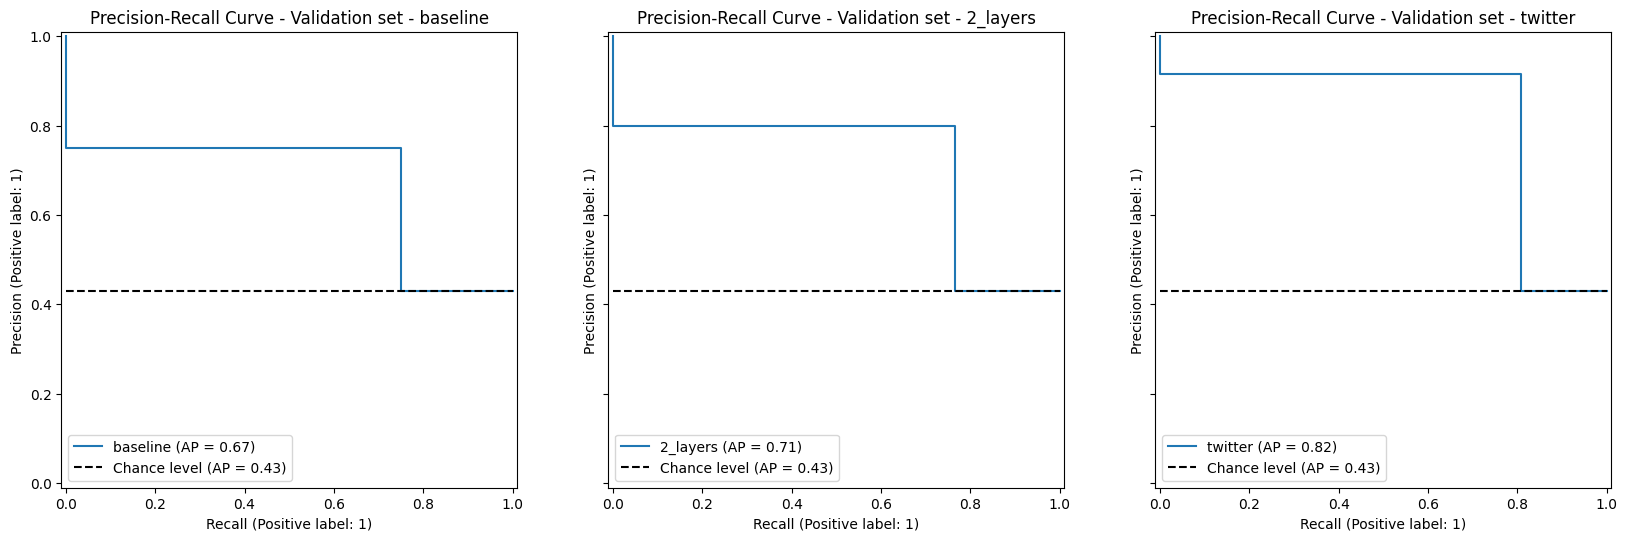

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot the precision-recall curve for each of the models Cardiff Twitter RoBERTa Base
for i, model_name in enumerate(list(metrics.ensembled_dict.keys())):
    predictions = metrics.ensembled_dict[model_name]['val']['predictions']
    labels = metrics.ensembled_dict[model_name]['val']['labels']
    metrics.get_precision_recall(predictions, labels, model_name, f"Precision-Recall Curve - Validation set - {model_name}", ax=ax[i])

* the baseline model, the Precision-Recall curve shows moderate performance (AP = 0.67).
* the two layer LSTM model, the Precision-Recall curve shows improvement (AP = 0.71). The confusion matrix reveals a tendency to misclassify sexist tweets as non-sexist, indicating a bias towards false negatives.
* the transformer model, the Precision-Recall curve shows the best performance (AP = 0.82). Despite its superior performance, the confusion matrix indicates it still struggles more with identifying sexist tweets, similar to the two-layer LSTM model.

The Transformer model is the most effective overall, but all models have a tendency to misclassify sexist tweets as non-sexist. Improving the detection of sexist tweets could involve further model tuning or incorporating additional features to address this bias.

### Test set

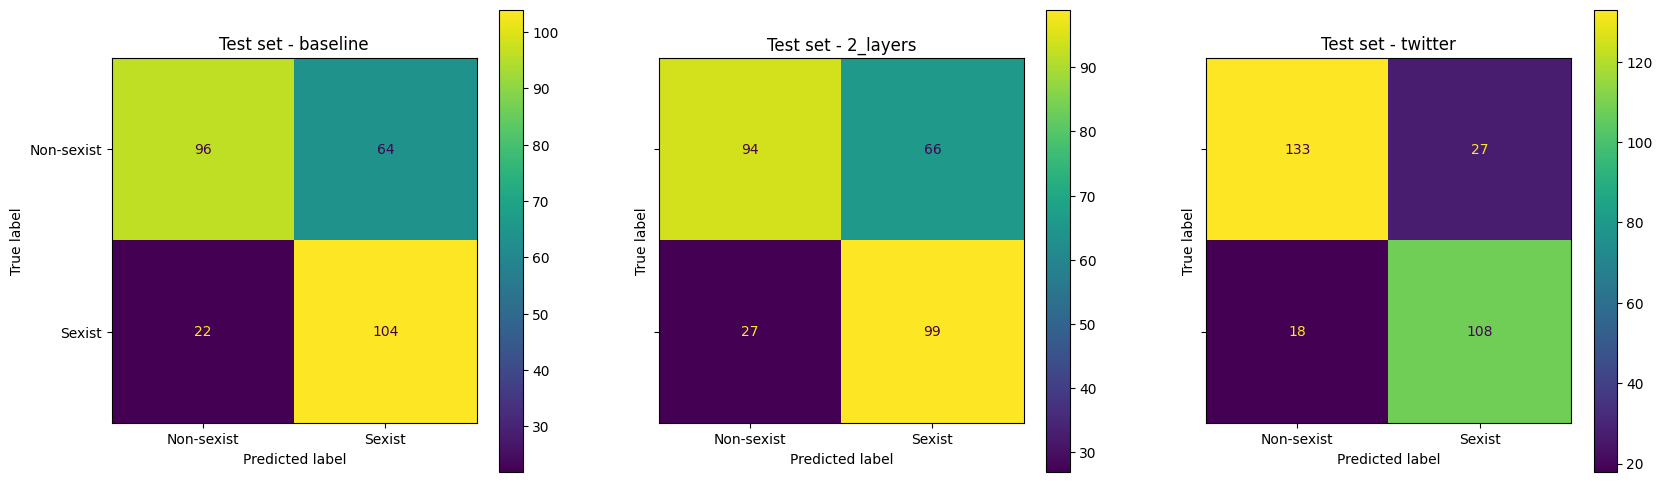

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot the confusion matrix for each of the models Cardiff Twitter RoBERTa Base on the test set
for i, model_name in enumerate(list(metrics.ensembled_dict.keys())):
    predictions = metrics.ensembled_dict[model_name]['test']['predictions']
    labels = metrics.ensembled_dict[model_name]['test']['labels']
    metrics.get_confusion_matrix(predictions, labels, title=f"Test set - {model_name}", ax=ax[i])

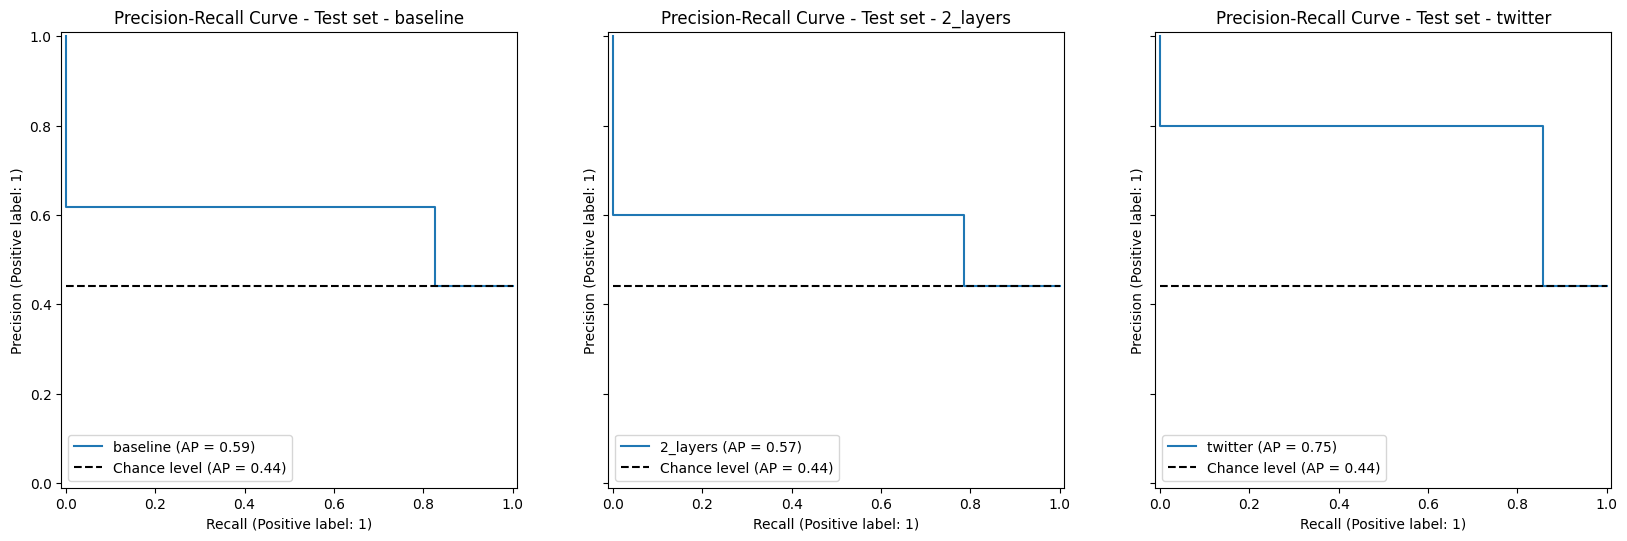

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot the precision-recall curve for each of the models Cardiff Twitter RoBERTa Base
for i, model_name in enumerate(list(metrics.ensembled_dict.keys())):
    predictions = metrics.ensembled_dict[model_name]['test']['predictions']
    labels = metrics.ensembled_dict[model_name]['test']['labels']
    metrics.get_precision_recall(predictions, labels, model_name, f"Precision-Recall Curve - Test set - {model_name}", ax=ax[i])

In [61]:
train.shape, val.shape, test.shape

((2870, 4), (158, 4), (286, 4))

In [62]:
train.label.value_counts(normalize=True), val.label.value_counts(normalize=True), test.label.value_counts(normalize=True) 

(label
 0    0.603833
 1    0.396167
 Name: proportion, dtype: float64,
 label
 0    0.56962
 1    0.43038
 Name: proportion, dtype: float64,
 label
 0    0.559441
 1    0.440559
 Name: proportion, dtype: float64)

The analysis of the confusion matrices and Precision-Recall curves for the test set reveals several insights. 
* The baseline LSTM model struggles with false positives, misclassifying many non-sexist tweets as sexist, and achieves a moderate average precision of 0.59.
* The two-layer LSTM model shows a similar pattern, with slightly worse performance, indicated by an average precision of 0.57. 
* Both models have difficulty generalizing to the test set, likely due to its larger size and complexity.

* The transformer model performs better overall, with an average precision of 0.75, but still misclassifies some non-sexist tweets. This suggests that while it is more effective than the LSTM models, there is still room for improvement, particularly in handling class imbalances.

<div class="alert alert-info">
<b> Note: </b>The drop in performance from the validation to the test set for all models indicates challenges in generalization. This could be addressed by data augmentation, balancing techniques, or further model tuning. Enhancing feature representation might also help capture the nuances between classes, especially for non-sexist tweets. It can also be due to the fact that the test set incorporates a wider range of tweets, making it more challenging for the models to generalize effectively.
</div>

### Misclassified tweets (test set)

The analysis of the misclassified tweets revealed that the majority of the misclassifications were due to the presence of OOV words. The models struggled to classify tweets containing slang, misspelled words, or uncommon terms, leading to misclassifications. This suggests that improving the handling of OOV words could enhance the models' performance.

In order to detect if the model is failing to classify the tweets because of the presence of OOV words we will print the misclassified tweets and see if they contain any OOV words. We also removed the special tokens as to be sure that the OOV words are not the special tokens but rather real OOV words.

In [63]:
wrong_ids_models = []

for model_name in metrics.ensembled_dict.keys():
    print(f"Errors for model {model_name}")
    wrong_tweet_ids = metrics.review_errors(preprocessed_data=test_data, predictions=metrics.ensembled_dict[model_name]['test']['predictions'], labels=metrics.ensembled_dict[model_name]['test']['labels'], tokenizer=tokenizer, verbose=False)
    wrong_ids_models.append(wrong_tweet_ids)

Errors for model baseline
Errors due to OOV: 86, 100.00%

Errors for model 2_layers
Errors due to OOV: 93, 100.00%

Errors for model twitter
Errors due to OOV: 44, 97.78%



### Sexism category analysis (baseline LSTM model)

Now given the results of the models we can perform an error analysis to understand the reasons why the models are failing to classify the tweets. We will use the ID of the misclassified tweets to retrieve the original example before the preprocessing and see if the model is failing to classify the tweets because of any specific reason.

In [64]:
error_df = test_copy[test_copy['id_EXIST'].isin(wrong_ids_models[0])]
error_df.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
400180,400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400185,400185,en,"“I mean I do, but… wouldn’t it be fun to get g...",6,"[Annotator_785, Annotator_786, Annotator_787, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, YES, YES]","[-, -, -, -, DIRECT, DIRECT]","[[-], [-], [-], [-], [SEXUAL-VIOLENCE], [OBJEC...",DEV_EN
400187,400187,en,@LogicalFallac18 @LBC Sex* as in 'gender' hara...,6,"[Annotator_791, Annotator_122, Annotator_396, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, NO, NO, NO, NO]","[-, REPORTED, -, -, -, -]","[[-], [IDEOLOGICAL-INEQUALITY, SEXUAL-VIOLENCE...",DEV_EN
400192,400192,en,"""𝐄𝐧𝐠𝐥𝐢𝐬𝐡 𝟏𝟎: Gender, Gender Identity, &amp; Se...",6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, NO, NO, YES, NO]","[-, JUDGEMENTAL, -, -, REPORTED, -]","[[-], [IDEOLOGICAL-INEQUALITY], [-], [-], [IDE...",DEV_EN
400194,400194,en,"""The violent antifeminism of a far-right movem...",6,"[Annotator_780, Annotator_781, Annotator_782, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, NO]","[REPORTED, REPORTED, REPORTED, DIRECT, REPORTE...","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",DEV_EN


We can extract the label of task 3 to understand if the model is failing to classify some specific category of sexism or if it is failing to classify all the categories of sexism.

The first explode is done to have the list of sexism categories in the dataframe. Since there are combinations of sexism categories in the same tweet, we need to explode the list of categories another time to have the single categories in the dataframe.

In this way we can understand if the model is failing to classify some specific category of sexism and in case which category it is failing to classify.

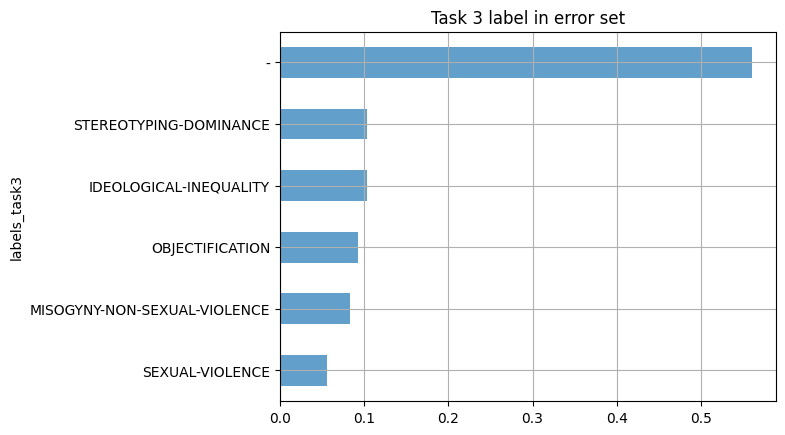

In [65]:
error_df['labels_task3'].explode().explode().value_counts(normalize=True, ascending=True).plot(kind='barh', title='Task 3 label in error set', alpha=0.7).set_xticklabels
plt.grid()
plt.savefig(detector.IMG_FOLDER / 'task3_error_set.svg', format='svg')
plt.show()

<div class="alert alert-info">
<b> Note: </b>From the analysis of the misclassified tweets, we can see that the baseline LSTM model detects very good the sexual violence in the tweets. All other categories are more or less equally misclassified by the models.
</div>

### Sexism category analysis (2 layer LSTM model)

In [66]:
error_df = test_copy[test_copy['id_EXIST'].isin(wrong_ids_models[1])]
error_df.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
400180,400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400184,400184,en,Suika gets gangbanged to death https://t.co/vn...,6,"[Annotator_780, Annotator_781, Annotator_782, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, YES]","[DIRECT, REPORTED, REPORTED, DIRECT, DIRECT, R...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION, SEX...",DEV_EN
400185,400185,en,"“I mean I do, but… wouldn’t it be fun to get g...",6,"[Annotator_785, Annotator_786, Annotator_787, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, YES, YES]","[-, -, -, -, DIRECT, DIRECT]","[[-], [-], [-], [-], [SEXUAL-VIOLENCE], [OBJEC...",DEV_EN
400187,400187,en,@LogicalFallac18 @LBC Sex* as in 'gender' hara...,6,"[Annotator_791, Annotator_122, Annotator_396, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, NO, NO, NO, NO]","[-, REPORTED, -, -, -, -]","[[-], [IDEOLOGICAL-INEQUALITY, SEXUAL-VIOLENCE...",DEV_EN
400192,400192,en,"""𝐄𝐧𝐠𝐥𝐢𝐬𝐡 𝟏𝟎: Gender, Gender Identity, &amp; Se...",6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, NO, NO, YES, NO]","[-, JUDGEMENTAL, -, -, REPORTED, -]","[[-], [IDEOLOGICAL-INEQUALITY], [-], [-], [IDE...",DEV_EN


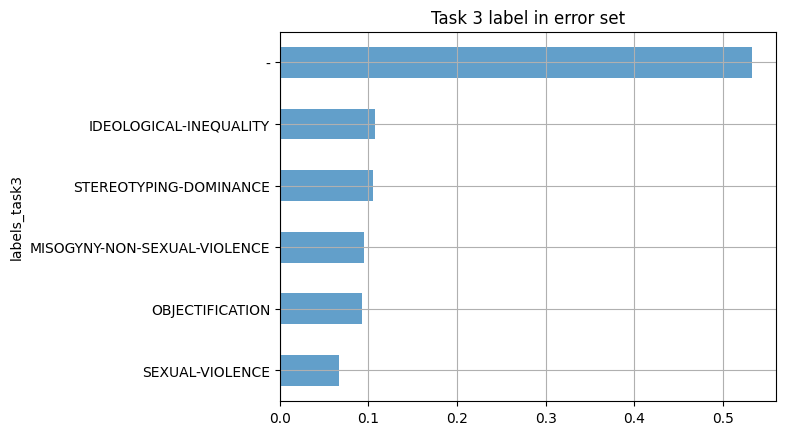

In [67]:
error_df['labels_task3'].explode().explode().value_counts(normalize=True, ascending=True).plot(kind='barh', title='Task 3 label in error set', alpha=0.7).set_xticklabels
plt.grid()
plt.savefig(detector.IMG_FOLDER / 'task3_error_set.svg', format='svg')
plt.show()

<div class="alert alert-info">
<b> Note: </b>The same applies to the two layer LSTM model. The model detects very well the sexual violence in the tweets (less number of misclassified tweets) with the other categories being more or less equally misclassified by the model. Differences with the baseline model are not so big, categories are just in a different order in the barplot.
</div>

### Sexism category analysis (transformer model)

In [68]:
error_df = test_copy[test_copy['id_EXIST'].isin(wrong_ids_models[2])]
error_df.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
400185,400185,en,"“I mean I do, but… wouldn’t it be fun to get g...",6,"[Annotator_785, Annotator_786, Annotator_787, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, YES, YES]","[-, -, -, -, DIRECT, DIRECT]","[[-], [-], [-], [-], [SEXUAL-VIOLENCE], [OBJEC...",DEV_EN
400187,400187,en,@LogicalFallac18 @LBC Sex* as in 'gender' hara...,6,"[Annotator_791, Annotator_122, Annotator_396, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, NO, NO, NO, NO]","[-, REPORTED, -, -, -, -]","[[-], [IDEOLOGICAL-INEQUALITY, SEXUAL-VIOLENCE...",DEV_EN
400189,400189,en,Appreciate being included along with @wphillip...,6,"[Annotator_776, Annotator_777, Annotator_195, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, YES, YES, NO, NO]","[-, -, REPORTED, REPORTED, -, -]","[[-], [-], [OBJECTIFICATION], [STEREOTYPING-DO...",DEV_EN
400199,400199,en,@EyemotionFandom How did we reach a point wher...,6,"[Annotator_780, Annotator_781, Annotator_782, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, NO, NO, NO, NO]","[DIRECT, DIRECT, -, -, -, -]","[[IDEOLOGICAL-INEQUALITY, OBJECTIFICATION], [S...",DEV_EN
400202,400202,en,@Catoishere @HatClub @RahnniFitteds That gold ...,6,"[Annotator_785, Annotator_786, Annotator_787, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, NO, YES, YES]","[-, DIRECT, DIRECT, -, DIRECT, REPORTED]","[[-], [STEREOTYPING-DOMINANCE, MISOGYNY-NON-SE...",DEV_EN


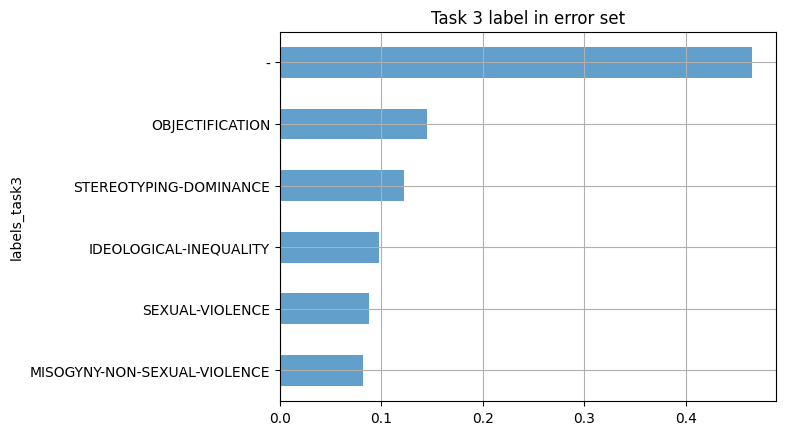

In [69]:
error_df['labels_task3'].explode().explode().value_counts(normalize=True, ascending=True).plot(kind='barh', title='Task 3 label in error set', alpha=0.7).set_xticklabels
plt.grid()
plt.savefig(detector.IMG_FOLDER / 'task3_error_set.svg', format='svg')
plt.show()

From the analysis above we can see that the model is failing to classify mainly tweets that do not fall into any category of sexism. The second most common category of sexism that the model is failing to classify is the category of `objectification` followed by the category of `stereotyping`. Moreover, the least common category of sexism that the model is failing to classify is the category of `misogyny` and `non-sexual-violence`. 

<div class="alert alert-warning">
<b>This is important</b> to note since the model has learned to classify the tweets that fall into the category of `misogyny` and `non-sexual-violence` better than the other categories of sexism. The misogyny and non-sexual-violence categories are the categories which contains the most implicit sexist language and the model is able to detect them better than the other categories of sexism.
</div>

# Appendix

Here we will add some additional information computation that we did not include in the main part of the notebook.

### Multilingual Model (Spanish and English tweets)

We experimented with the multilinguality of the dataset by training the model on both Spanish and English tweets. We used the same preprocessing pipeline as for the English tweets, but we used a transformer model trained on multilingual data. The model we used is `xlm-roberta-base` which is trained on multilingual data. We trained the model on both the English and Spanish tweets and evaluated it on the same test set of the English only model. The results are shown below.

For the sake of simplicity we will just evaluate the numerical performance of the model rather than doing all the error analysis and the confusion matrix.

The training procedure is the same as the one used for the English tweets. We will train the model for 6 epochs and evaluate it on both the validation and test set.

In [70]:
detector = SexismDetector()

In [71]:
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/training.json', filename='training.json')
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/test.json', filename='test.json')
detector.download_corpus(url='https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/validation.json', filename='validation.json')

In [72]:
train = detector.load_corpus('training.json', orient='index', encoding='utf-8')
val = detector.load_corpus('validation.json', orient='index', encoding='utf-8')
test = detector.load_corpus('test.json', orient='index', encoding='utf-8')

In [73]:
train['hard_label_task1'] = train['labels_task1'].apply(detector.majority_voting)
val['hard_label_task1'] = val['labels_task1'].apply(detector.majority_voting)
test['hard_label_task1'] = test['labels_task1'].apply(detector.majority_voting)

In [74]:
train = train[(train['hard_label_task1'] != "NEUTRAL")]
val = val[(val['hard_label_task1'] != "NEUTRAL")]
test = test[(test['hard_label_task1'] != "NEUTRAL")]

In [75]:
train.shape, val.shape, test.shape

((6064, 12), (648, 12), (286, 12))

In [76]:
test_data.to_pandas().lang.value_counts()

lang
en    286
Name: count, dtype: int64

In [77]:
train = train[detector.columns_to_maintain]
val = val[detector.columns_to_maintain]
test = test[detector.columns_to_maintain]

In [78]:
train['hard_label_task1'] = train['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)
val['hard_label_task1'] = val['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)
test['hard_label_task1'] = test['hard_label_task1'].apply(lambda x: 1 if x == "YES" else 0)

In [79]:
train.rename(columns={'hard_label_task1': 'label'}, inplace=True)
val.rename(columns={'hard_label_task1': 'label'}, inplace=True)
test.rename(columns={'hard_label_task1': 'label'}, inplace=True)

The distribution of the labels is shown. As we can see, the unbalanced distribution of the labels is maintained in the Spanish tweets as well but less pronounced than in the English tweets.

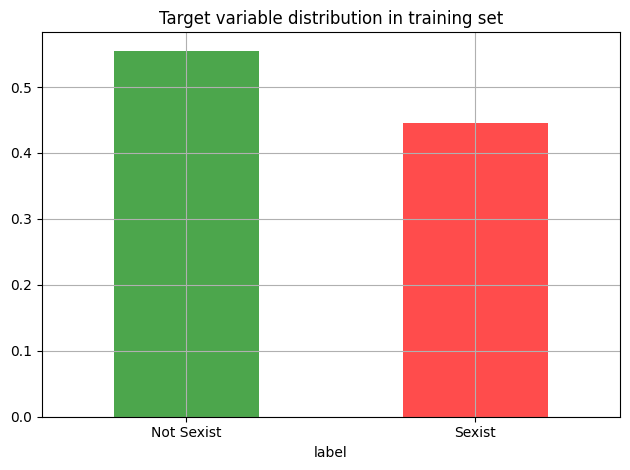

In [80]:
train.label.value_counts(normalize=True).plot(kind='bar', title='Target variable distribution in training set', color=['green', 'red'], alpha=0.7).set_xticklabels(['Not Sexist', 'Sexist'], rotation=0)
plt.grid()
plt.tight_layout()
plt.show()

Using both Spanish and English tweets, the label distribution is more balanced (approximately 55:45) compared to the English-only dataset. This could affect the model's performance, as it has more examples of each class to learn from.

We still decided to include the class weight technique to deal with the class imbalance in the dataset.

In [81]:
class_weights_tensor_multi = detector.get_class_weights(train, 'label')
class_weights_tensor_multi

tensor([0.9005, 1.1242])

In [82]:
train['tweet'] = train['tweet'].apply(detector.preprocess_text)
val['tweet'] = val['tweet'].apply(detector.preprocess_text)
test['tweet'] = test['tweet'].apply(detector.preprocess_text)

In [83]:
train['tweet'] = train['tweet'].apply(detector.lemmatize_text)
val['tweet'] = val['tweet'].apply(detector.lemmatize_text)
test['tweet'] = test['tweet'].apply(detector.lemmatize_text)

In [84]:
train['tweet'] = train['tweet'].str.lower()
val['tweet'] = val['tweet'].str.lower()
test['tweet'] = test['tweet'].str.lower()

In [85]:
train.head()

,id_EXIST,lang,tweet,label
100001,100001,es,<user> ignora al otro e un capullo el problema...,1
100002,100002,es,<user> si comicsgate se parece en algo a gamer...,0
100003,100003,es,<user> lee sobre gamergate y como eso ha cambi...,0
100005,100005,es,<user> <user> <user> entonces como asi e el me...,1
100006,100006,es,<user> aaah si andrew dobson el que se dedico ...,0


In [86]:
# Since we know that there is a slightly imbalance in the dataset labels, instead of using the default Trainer class of HuggingFace, we can write a custom class inheriting from the Trainer class and override the `compute_loss` method to compute the loss with the class weights computed from the dataset labels. In this way the loss function will take into account the imbalance in the dataset labels and will give more importance to the minority class. The impact of this change is that the F1 and accuracy scores will be more similar to each other since the model will be trained to give more importance to the minority class w.r.t. the majority class.

# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, class_weights, device, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # You pass the class weights when instantiating the Trainer
        self.class_weights = class_weights
        self.device = device

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We don't use .loss here since the model may return tuples instead of ModelOutput.

            # Do not
            # loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
            logits = outputs.get('logits')
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(self.device))
            loss = criterion(logits, inputs['labels'])

        return (loss, outputs) if return_outputs else loss

In [87]:
def compute_metrics(output_info):
        """
        Compute various evaluation metrics for model predictions.

        Args:
            output_info (tuple): A tuple containing the model predictions and the true labels.
                - predictions (np.ndarray): The predicted labels from the model.
                - labels (np.ndarray): The true labels.

        Returns:
            dict: A dictionary containing the computed metrics:
                - 'f1': The F1 score (macro average).
                - 'accuracy': The accuracy score.
                - 'precision': The precision score (macro average).
                - 'recall': The recall score (macro average).
        """
        #acc_metric = evaluate.load('accuracy')
        #f1_metric = evaluate.load('f1')
        #precision_metric = evaluate.load("precision")
        #recall_metric = evaluate.load("recall")

        predictions, labels = output_info
        #LINE REMOVED
        predictions = np.array(predictions)
        labels = np.array(labels)
        predictions = np.argmax(predictions, axis=-1)



        #f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')
        #acc = acc_metric.compute(predictions=predictions, references=labels)
        #precision = precision_metric.compute(predictions=predictions, references=labels, average='macro')
        #recall = recall_metric.compute(predictions=predictions, references=labels, average='macro')

        f1 = f1_score(labels, predictions, average="macro")
        acc = accuracy_score(labels, predictions)
        prec = precision_score(labels, predictions, average="macro")
        rec = recall_score(labels,predictions, average="macro")

        return {"f1-score" : f1, "Accuracy" : acc, "Precision":prec, "Recall":rec}

In [88]:
# Get the train, val and test datasets
train_data = Dataset.from_pandas(train)
val_data = Dataset.from_pandas(val)
test_data = Dataset.from_pandas(test)

# Define the model card
model_card = "xlm-roberta-base"

# Get the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_card, use_Fast=False)

def preprocess_text(texts):
    return tokenizer(texts['tweet'])

# Select the right column
train_data = train_data.map(preprocess_text, batched=True)
val_data = val_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)

# Get the data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

In [89]:
def twitter_roberta_base(model_card: str, seed: int, class_weights: torch.Tensor, train_data: Dataset, val_data: Dataset, test_data: Dataset, data_collator, device: torch.device):

    # Set the flag to False
    already_fine_tuned = False

    # Get model name
    model_name = model_card.split('/')[-1]

    # Clear the cache and perform garbage collection
    with torch.no_grad():
        torch.cuda.empty_cache()

    gc.collect()

    # Try to fetch the model from the HuggingFace Hub (if it exists)
    try:
        # Model already fine-tuned
        model = XLMRobertaForSequenceClassification.from_pretrained(f'MatteoFasulo/{model_name}_{seed}', num_labels=2, id2label={0: 'NEG', 1: 'POS'}, label2id={'NEG': 0, 'POS': 1})
        already_fine_tuned = True

    except:
        model = XLMRobertaForSequenceClassification.from_pretrained(model_card, num_labels=2, id2label={0: 'NEG', 1: 'POS'}, label2id={'NEG': 0, 'POS': 1})

    # Get the training arguments
    training_args = TrainingArguments(
        output_dir=f'{model_name}_{seed}',                 # where to save model
        learning_rate=ROBERTA_LEARNING_RATE,
        per_device_train_batch_size=ROBERTA_BATCH_SIZE,         # accelerate defines distributed training
        per_device_eval_batch_size=ROBERTA_BATCH_SIZE,
        num_train_epochs=ROBERTA_EPOCHS,
        weight_decay=1e-5,
        eval_strategy="epoch",           # when to report evaluation metrics/losses
        save_strategy="epoch",                 # when to save checkpoint
        save_safetensors=True,           # save model with safe tensors
        torch_empty_cache_steps=379,
        load_best_model_at_end=True,
        report_to='none',                    # disabling wandb (default)
        seed=seed,
        data_seed=seed
    )

    # Get the trainer
    trainer = CustomTrainer(
                model=model,
                args=training_args,
                train_dataset=train_data,
                eval_dataset=test_data,
                data_collator=data_collator,
                compute_metrics=compute_metrics,
                class_weights=class_weights,
                device=device,
            )

    if not already_fine_tuned:
        # Train the model
        trainer.train()

    # Get the predictions for the validation set
    val_predictions_info = trainer.predict(val_data)
    val_predictions, val_labels = val_predictions_info.predictions, val_predictions_info.label_ids

    # Transpose the predictions and get the argmax
    val_predictions = np.argmax(val_predictions, axis=1)

    # Get the predictions for the test set
    test_predictions_info = trainer.predict(test_data)
    test_predictions, test_labels = test_predictions_info.predictions, test_predictions_info.label_ids

    # Transpose the predictions and get the argmax
    test_predictions = np.argmax(test_predictions, axis=1)

    # Update the predictions dict with the new predictions
    predictions_dict[f'{model_name}_{seed}'] = {'val': {}, 'test': {}}
    predictions_dict[f'{model_name}_{seed}']['val'] = {'predictions': val_predictions, 'labels': val_labels}
    predictions_dict[f'{model_name}_{seed}']['test'] = {'predictions': test_predictions, 'labels': test_labels}

    print(f"Validation set metrics for model {model_name}_{seed}:\n{val_predictions_info.metrics}\n")
    print(f"Test set metrics for model {model_name}_{seed}:\n{test_predictions_info.metrics}\n")

    if not already_fine_tuned:
        # Push the model to HuggingFace Hub
        trainer.push_to_hub()

In [90]:
twitter_roberta_base(
    model_card = model_card,
    seed = 1337,
    class_weights = class_weights_tensor_multi,
    train_data = train_data,
    val_data= val_data,
    test_data = test_data,
    data_collator = data_collator,
    device=device
)

Validation set metrics for model xlm-roberta-base_1337:
{'test_loss': 0.35835689306259155, 'test_model_preparation_time': 0.0057, 'test_f1-score': 0.8502997292077004, 'test_Accuracy': 0.8503086419753086, 'test_Precision': 0.8503086419753086, 'test_Recall': 0.8503920877361817, 'test_runtime': 1.0472, 'test_samples_per_second': 618.818, 'test_steps_per_second': 39.154}

Test set metrics for model xlm-roberta-base_1337:
{'test_loss': 0.41384434700012207, 'test_model_preparation_time': 0.0057, 'test_f1-score': 0.824134199134199, 'test_Accuracy': 0.8251748251748252, 'test_Precision': 0.8234919702311007, 'test_Recall': 0.8277281746031746, 'test_runtime': 0.4556, 'test_samples_per_second': 627.744, 'test_steps_per_second': 39.508}



In [91]:
twitter_roberta_base(
    model_card = model_card,
    seed = 42,
    class_weights = class_weights_tensor_multi,
    train_data = train_data,
    val_data= val_data,
    test_data = test_data,
    data_collator = data_collator,
    device=device
)

Validation set metrics for model xlm-roberta-base_42:
{'test_loss': 0.352009654045105, 'test_model_preparation_time': 0.0057, 'test_f1-score': 0.8687568355814801, 'test_Accuracy': 0.8688271604938271, 'test_Precision': 0.8689404630229987, 'test_Recall': 0.8686768110832674, 'test_runtime': 1.0472, 'test_samples_per_second': 618.802, 'test_steps_per_second': 39.153}

Test set metrics for model xlm-roberta-base_42:
{'test_loss': 0.45670345425605774, 'test_model_preparation_time': 0.0057, 'test_f1-score': 0.8105960264900662, 'test_Accuracy': 0.8111888111888111, 'test_Precision': 0.8116197183098591, 'test_Recall': 0.8160714285714286, 'test_runtime': 0.454, 'test_samples_per_second': 629.937, 'test_steps_per_second': 39.646}



In [92]:
twitter_roberta_base(
    model_card = model_card,
    seed = 69,
    class_weights = class_weights_tensor_multi,
    train_data = train_data,
    val_data= val_data,
    test_data = test_data,
    data_collator = data_collator,
    device=device
)

Validation set metrics for model xlm-roberta-base_69:
{'test_loss': 0.4418230950832367, 'test_model_preparation_time': 0.0057, 'test_f1-score': 0.8472218583815786, 'test_Accuracy': 0.8472222222222222, 'test_Precision': 0.8473704268292683, 'test_Recall': 0.8474002153385867, 'test_runtime': 1.0356, 'test_samples_per_second': 625.697, 'test_steps_per_second': 39.589}

Test set metrics for model xlm-roberta-base_69:
{'test_loss': 0.47489017248153687, 'test_model_preparation_time': 0.0057, 'test_f1-score': 0.8448717948717949, 'test_Accuracy': 0.8461538461538461, 'test_Precision': 0.8437745483110761, 'test_Recall': 0.8473214285714286, 'test_runtime': 0.4537, 'test_samples_per_second': 630.397, 'test_steps_per_second': 39.675}



In [93]:
metrics = Metrics(predictions_dict=predictions_dict)

# Get the ensemble predictions
metrics.majority_voting()

Here we will evaluate the f1 macro score of the XLM RoBERTa model on the validation set.

The test set contains only English tweets and not even a single Spanish tweet.

In [94]:
# Calculate the F1 score for each of the ensembled models
f1_scores_ensembled = {model_name: metrics.get_f1_score(metrics.ensembled_dict[model_name]['val']['predictions'], metrics.ensembled_dict[model_name]['val']['labels']) for model_name in metrics.ensembled_dict.keys()}
accuracy_ensembled = {model_name: accuracy_score(metrics.ensembled_dict[model_name]['val']['labels'], metrics.ensembled_dict[model_name]['val']['predictions']) for model_name in metrics.ensembled_dict.keys()}
print(f"F1 for the validation set of ensembled models: {f1_scores_ensembled}")
print(f"Accuracy for the validation set of ensembled models: {accuracy_ensembled}")

F1 for the validation set of ensembled models: {'baseline': 0.7805555555555556, '2_layers': 0.8117424709314269, 'twitter': 0.8818151595744681, 'xlm': 0.8626382917912137}
Accuracy for the validation set of ensembled models: {'baseline': 0.7848101265822784, '2_layers': 0.8164556962025317, 'twitter': 0.8860759493670886, 'xlm': 0.8626543209876543}


From the output metrics we can see that the model achives an f1 macro score of 0.85 on the validation set which includes both English and Spanish tweets. This is a good performance of the model and it shows that the model is able to generalize well on both English and Spanish tweets.

In [95]:
# Calculate the F1 score for each of the ensembled models
f1_scores_ensembled = {model_name: metrics.get_f1_score(metrics.ensembled_dict[model_name]['test']['predictions'], metrics.ensembled_dict[model_name]['test']['labels']) for model_name in metrics.ensembled_dict.keys()}
accuracy_ensembled = {model_name: accuracy_score(metrics.ensembled_dict[model_name]['test']['labels'], metrics.ensembled_dict[model_name]['test']['predictions']) for model_name in metrics.ensembled_dict.keys()}
print(f"F1 for the test set of ensembled models: {f1_scores_ensembled}")
print(f"Accuracy for the test set of ensembled models: {accuracy_ensembled}")

F1 for the test set of ensembled models: {'baseline': 0.6990652376058337, '2_layers': 0.6747257585207469, 'twitter': 0.8414458365672469, 'xlm': 0.831343063541206}
Accuracy for the test set of ensembled models: {'baseline': 0.6993006993006993, '2_layers': 0.6748251748251748, 'twitter': 0.8426573426573427, 'xlm': 0.8321678321678322}


Talking about the performance over the test set (which has only English tweets), the model has a good performance achieving a f1 macro score of 0.82 so just slightly worse than the transformer model trained on English tweets only. This is a good result since this model is not originally fine-tuned on the hate speech detection task (neither on the sexism detection task) and it is trained on multilingual data.

---

### Dashboard

We have also developed a Dashboard to visualize the results of the models and experiment using both the english-only as well as the multilingual model. The Dashboard is developed using the `gradio` library and is available directly on the Hugging Face space at the following link: https://huggingface.co/spaces/MatteoFasulo/Sexism-Detection-Dashboard